In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in note"book, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is the second attempt to read in track information and use it to predict the KDE used as input to PvFinder. This time, we are reading in poca KDEs rather than the original KDEs. 

collectdata_kde_C.py uses poca_z, poca_x, poca_y, major_axis_x, major_axis_y, and major_axis_z as the six track parameters (for the moment)


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Mon Sep 13 13:26:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN V      Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   39C    P2    34W / 250W |   1223MiB / 12066MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

This notebook is first attempt to read in track information and use it to predict the KDE used as input to PvFinder.


## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 50

# Name is the output file name


##  201027 -- about to go to bed, so try 2500 epochs with lr = 1e55
##  previous iteration had l4 = 3e-5 and cost dropped almost linearly
##  for 100 epochs -- final training costs ~ 2.02, validation cost ~ 2.01

## for iter 4, try 10 epochs with lr = 3e-6
## usually have a big jump down at epoch 0; want to try a
## small number of epochs per iteration and see what happens (iter4: 10 epochs gave
## traiing cost dropping from 1.54 to 1.50 immediately, then dropping very slowly)
folder = 'GoodVersion_DDplus_iter1_adaptivenet_carefulAdam_80kevents_1'
name   = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'baileyds/DDplus/' + folder
output = Path(folder)


# Size of batches
batch_size = 16 ## was 64
# How fast to learn
learning_rate = 2e-5

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_B import collect_t2kde_data
## collectdata_kde_C should use the new poca KDE rather than the original kernel KDE
from model.collectdata_kde_Ellipsoids import collect_t2kde_data


# From model/loss.py
##from loss import Loss
## kde_loss_D includes botha ratio term and a chisq term, 98% ave_chisq
## kde_loss_E adds a chi^4 term to the kde_loss_D return value
## this is intended to emphasize the importance of values significantly different than zero
from model.kde_loss_Ba import Loss

##  TracksToKDE_Ellipsoids_SevenLayerCake has 7 hidden layers producing the 4000-bin KDE historgram
##  It takes 9 input features (pocca centers + (A,B,C,D,E,F) . 
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as Model


from model.training_kde import trainNet, select_gpu, Results
from functions.my_training_kde import adaptivetrainNet
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)
# my entry 
from functions.utils import get_param_state
param_states = []

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = "cuda:0"#select_gpu(0)
##device = "cpu"

## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [9]:
##print("Let's use", torch.cuda.device_count(), "GPUs!")
##if torch.cuda.device_count() > 1:
##    model = torch.nn.DataParallel(model)

In [10]:
## a comment on the web at https://pytorch.org/docs/stable/optim.html says
"""
If you need to move a model to GPU via .cuda(), please do so before constructing optimizers for it. 
Parameters of a model after .cuda() will be different objects with those before the call.

In general, you should make sure that optimized parameters live in consistent locations when 
optimizers are constructed and used.
"""
## so move this here (although we are using model.to(device) not explicitly using .cuda()

nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model = Model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
##  loss = Loss(epsilon=1e-5,coefficient=2.5)
##loss = Loss(epsilon=3e-5, debug=False)
loss = Loss(epsilon=3e-5)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
model = model.to(device)

In [12]:
from functions.mod_adam import epoch_Reversible_Adam
optimizer = epoch_Reversible_Adam(model.parameters(), lr=learning_rate)
##optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
##    print("value = ", v)
 
updated_dict = model_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]

model.load_state_dict(updated_dict,strict=False)

model_dict = model.state_dict()
##print("updated model_dict = ",model_dict)

## print(" \n","  for pretrained_dict")
## index = 0
##for k,v in pretrained_dict.items():
##    print("index, k =  ",index,"  ",k)
##    index = index+1
## mds  

##pretrained_dict = torch.load('ML/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50/29July2020_Trks_to_KDE_C_lossB_100epochs_b64_1m3_nOut_50x50_final.pyt')
##print("model_dict instantiated")
# 1. filter out unnecessary keys
##pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
##print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
##model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

##model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)

# ## finished at training cost = 1.46, validation cost = 1.50
d_folder = 'GoodVersion_DDplus_iter0_adaptivenet_carefulAdam_80kevents_1'
d_name = d_folder
suffix = 'final'
dict_name = 'baileyds/DDplus/' + d_folder + '/' + d_name + '_'+ suffix + '.pyt'
print('dict_name = ',dict_name)
pretrained_dict = torch.load(dict_name)

# print(" ")
# print("  for pretrained_dict")
# index = 0
# for k,v in pretrained_dict.items():
#     print("index, k =  ",index,"  ",k)
#     index = index+1
 

# ##print("model_dict instantiated")
# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# print("pretrained_dict iterated")
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# ##
# #   when starting from a model with a fully connected last layer rather than a convolutional layer
# # 3. load the new state dict
# #   need to use strict=False as the two models state model attributes do not agree exactly
# #   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

#mine
torch.save(model.state_dict(), output / f'{name}_init.pyt')
param_states.append(get_param_state(model))


output =  baileyds/DDplus/GoodVersion_DDplus_iter1_adaptivenet_carefulAdam_80kevents_1
for model_dict
index, k =   0    layer1.weight
index, k =   1    layer1.bias
index, k =   2    layer2.weight
index, k =   3    layer2.bias
index, k =   4    layer3.weight
index, k =   5    layer3.bias
index, k =   6    layer4.weight
index, k =   7    layer4.bias
index, k =   8    layer5.weight
index, k =   9    layer5.bias
index, k =   10    layer6.weight
index, k =   11    layer6.bias
index, k =   12    layer7.weight
index, k =   13    layer7.bias
index, k =   14    layer8.weight
index, k =   15    layer8.bias
index, k =   16    layer9.weight
index, k =   17    layer9.bias
index, k =   18    layer10.weight
index, k =   19    layer10.bias
index, k =   20    layer11.weight
index, k =   21    layer11.bias
index, k =   22    layer12new.weight
index, k =   23    layer12new.bias
index, k =   24    conv1.weight
index, k =   25    conv1.bias
index, k =   26    conv2.weight
index, k =   27    conv2.bias
inde

In [14]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [15]:

## Training dataset. You can put as many files here as desired.

##train_loader = collect_t2kde_data('/share/lazy/pv-finder/20k_evts_for_KDE_learning_200716.h5',
train_loader = collect_t2kde_data('/share/lazy/will/data/June30_2020_80k_1.h5', 
                               # '/share/lazy/will/data/June30_2020_80k_2.h5',
                                #'/share/lazy/will/data/June30_2020_80k_3.h5',
                                #'/share/lazy/will/data/June30_2020_80k_4.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPwU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
        #                  device=device,
                          #slice = slice(None,60000)
                           )
                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2kde_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
##                            device=device,
  #                          slice = slice(18000,None)
                           )


Loading data...
pocaMx.shape =  (80000,)
nEvts =  80000
len(pocaMx[0]) =  199
len(pocaMx[1]) =  25
len(pocaMx[2]) =  369
len(pocaMx[3]) =  143
len(pocaMx[4]) =  160
majorAxis.shape =  (80000, 3)
minorAxis_1.shape =  (80000, 3)
minorAxis_2.shape =  (80000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  80000
 iEvt, nTrks =  0 199
 iEvt, nTrks =  1 25
 iEvt, nTrks =  2 369
 iEvt, nTrks =  3 143
 iEvt, nTrks =  4 160
 iEvt, nTrks =  5 260
 iEvt, nTrks =  6 237
 iEvt, nTrks =  7 327
 iEvt, nTrks =  8 178
 iEvt, nTrks =  9 106
A.shape =  (80000,)
majorAxis[iTrk][0][0] =  0.00045611936
majorAxis[iTrk][1][0] =  -4.8292455e-05
majorAxis[iTrk][2][0] =  0.090019904
minorAxis_1[iTrk][0][0] =  -1.8602173
minorAxis_1[iTrk][1][0] =  -17.569641
minorAxis_1[iTrk][2][0] =  4.7891795e-08
minorAxis_2[iTrk][0][0] =  -17.569414
minorAxis_2[iTrk][1][0] =  1.8601931
minorAxis_2[iTrk][2][0] =  0.0900199
  
majorAxis[iTrk][0][0] =  0.002360258
majorAxis[iTrk][1][0] =  -0.007426616
majorAxis[iTrk][2][

len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 38.11 s
outer loop X.shape =  (20000, 9, 600)
Constructing 20000 event dataset took 0.1883 s
x_t.shape =  torch.Size([20000, 9, 600])
x_t.shape[0] =  20000
x_t.shape[1] =  9
x_t.shape =  torch.Size([20000, 9, 600])


<IPython.core.display.Javascript object>


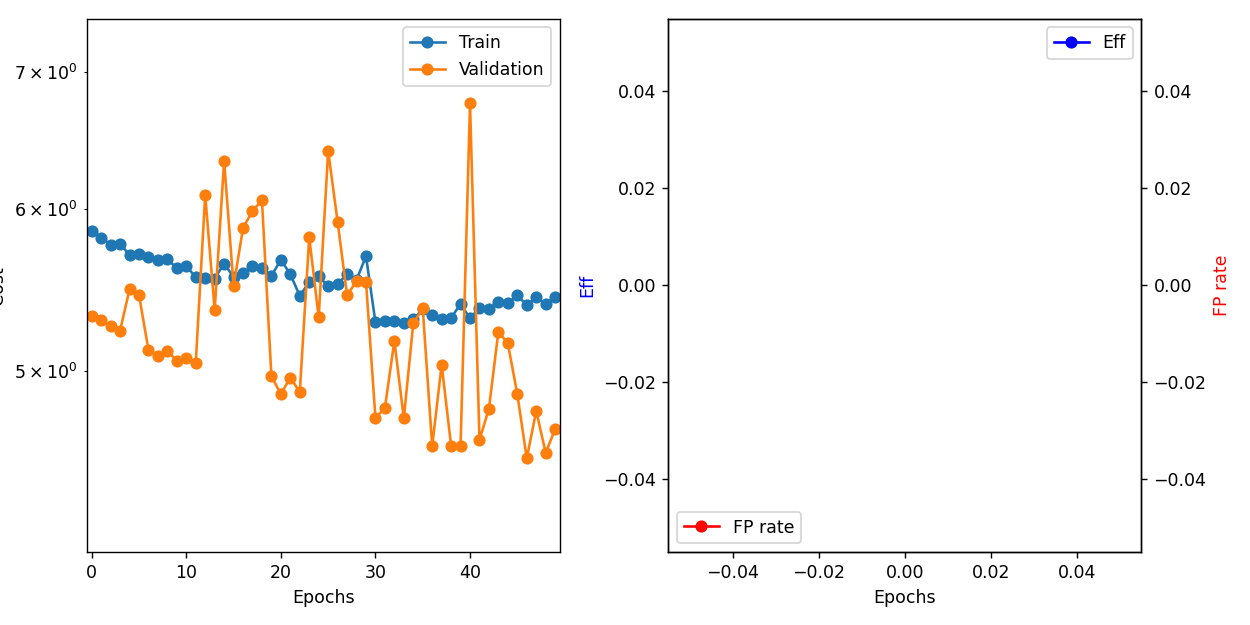

In [16]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [17]:
for result in adaptivetrainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        loss_increase_limit = 0.02, lr_factor = 0.8, lr_increase_factor = 0.05,
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)

    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')
    #mine
    param_states.append(get_param_state(model))

Number of batches: train = 5000, val = 1250


Number of batches: train = 5000, val = 1250


new cost: 5.8514982650756835 | old cost: 1000000.0
Epoch 0: train=5.8515, val=5.31761, took 334.28 s


new cost: 5.806876371860504 | old cost: 5.8514982650756835
num: tensor(8.7606, device='cuda:0')
denom: tensor(17.1324, device='cuda:0')
dot: 0.5113486 | ratio: 1.0255674302577973
lr changed to 2.0511348605155946e-05
Epoch 1: train=5.80688, val=5.29255, took 330.09 s


new cost: 5.762402921915054 | old cost: 5.806876371860504
num: tensor(8.4598, device='cuda:0')
denom: tensor(16.3840, device='cuda:0')
dot: 0.5163449 | ratio: 1.0258172452449799
lr changed to 2.1040895122400533e-05
Epoch 2: train=5.7624, val=5.25652, took 331.5 s


new cost: 5.767668982505798 | old cost: 5.762402921915054
num: tensor(8.4294, device='cuda:0')
denom: tensor(16.7640, device='cuda:0')
dot: 0.5028267 | ratio: 1.0251413345336915
lr changed to 2.1569891305561122e-05
Epoch 3: train=5.76767, val=5.23059, took 330.28 s


new cost: 5.693711498260498 | old cost: 5.767668982505798
num: tensor(8.5422, device='cuda:0')
denom: tensor(17.3793, device='cuda:0')
dot: 0.49151617 | ratio: 1.0245758086442946
lr changed to 2.2099988826764827e-05
Epoch 4: train=5.69371, val=5.47995, took 357.09 s


new cost: 5.70373289937973 | old cost: 5.693711498260498
num: tensor(8.6368, device='cuda:0')
denom: tensor(17.9719, device='cuda:0')
dot: 0.48057446 | ratio: 1.0240287229418754
lr changed to 2.2631023335301702e-05
Epoch 5: train=5.70373, val=5.44377, took 334.78 s


new cost: 5.683058258962631 | old cost: 5.70373289937973
num: tensor(8.7235, device='cuda:0')
denom: tensor(18.4445, device='cuda:0')
dot: 0.47295794 | ratio: 1.0236478969454765
lr changed to 2.3166199442905592e-05
Epoch 6: train=5.68306, val=5.11849, took 341.72 s


new cost: 5.665273530960083 | old cost: 5.683058258962631
num: tensor(8.7535, device='cuda:0')
denom: tensor(19.0393, device='cuda:0')
dot: 0.45976126 | ratio: 1.022988063097
lr changed to 2.3698745497416795e-05
Epoch 7: train=5.66527, val=5.08124, took 348.88 s


new cost: 5.667036439228058 | old cost: 5.665273530960083
num: tensor(8.8967, device='cuda:0')
denom: tensor(19.5377, device='cuda:0')
dot: 0.45535943 | ratio: 1.022767971456051
lr changed to 2.4238317858446196e-05
Epoch 8: train=5.66704, val=5.11307, took 339.17 s


new cost: 5.612841759347916 | old cost: 5.667036439228058
num: tensor(8.9660, device='cuda:0')
denom: tensor(20.1674, device='cuda:0')
dot: 0.4445794 | ratio: 1.0222289696335793
lr changed to 2.477711069009064e-05
Epoch 9: train=5.61284, val=5.05579, took 335.73 s


new cost: 5.624680652046203 | old cost: 5.612841759347916
num: tensor(9.0146, device='cuda:0')
denom: tensor(20.8372, device='cuda:0')
dot: 0.432618 | ratio: 1.0216308996081351
lr changed to 2.531306188400764e-05
Epoch 10: train=5.62468, val=5.06967, took 346.93 s


new cost: 5.553921813297272 | old cost: 5.624680652046203
num: tensor(9.2649, device='cuda:0')
denom: tensor(21.5808, device='cuda:0')
dot: 0.42931098 | ratio: 1.0214655488729476
lr changed to 2.5856420651002754e-05
Epoch 11: train=5.55392, val=5.04333, took 360.86 s


new cost: 5.549185710477829 | old cost: 5.553921813297272
num: tensor(9.3919, device='cuda:0')
denom: tensor(22.3257, device='cuda:0')
dot: 0.42067742 | ratio: 1.0210338711738587
lr changed to 2.6400281271993043e-05
Epoch 12: train=5.54919, val=6.09336, took 359.7 s


new cost: 5.545922619199753 | old cost: 5.549185710477829
num: tensor(9.3330, device='cuda:0')
denom: tensor(22.9797, device='cuda:0')
dot: 0.40613958 | ratio: 1.0203069791197776
lr changed to 2.6936391232539662e-05
Epoch 13: train=5.54592, val=5.35184, took 387.49 s


new cost: 5.640218333053589 | old cost: 5.545922619199753
num: tensor(9.0810, device='cuda:0')
denom: tensor(24.7007, device='cuda:0')
dot: 0.36764282 | ratio: 1.0183821409940719
lr changed to 2.743153977404769e-05
Epoch 14: train=5.64022, val=6.33076, took 339.19 s


new cost: 5.555454777812958 | old cost: 5.640218333053589
num: tensor(8.4056, device='cuda:0')
denom: tensor(25.3521, device='cuda:0')
dot: 0.33155468 | ratio: 1.016577734053135
lr changed to 2.7886292545089848e-05
Epoch 15: train=5.55545, val=5.49845, took 388.52 s


new cost: 5.578047497987747 | old cost: 5.555454777812958
num: tensor(9.1421, device='cuda:0')
denom: tensor(24.9428, device='cuda:0')
dot: 0.36652264 | ratio: 1.0183261319994927
lr changed to 2.8397340423247635e-05
Epoch 16: train=5.57805, val=5.87079, took 389.86 s


new cost: 5.627474144124985 | old cost: 5.578047497987747
num: tensor(8.9049, device='cuda:0')
denom: tensor(25.4710, device='cuda:0')
dot: 0.34960762 | ratio: 1.017480380833149
lr changed to 2.8893736748494578e-05
Epoch 17: train=5.62747, val=5.984, took 365.78 s


new cost: 5.614674273872375 | old cost: 5.627474144124985
num: tensor(8.6941, device='cuda:0')
denom: tensor(26.0458, device='cuda:0')
dot: 0.3337999 | ratio: 1.016689994931221
lr changed to 2.9375973068370986e-05
Epoch 18: train=5.61467, val=6.05639, took 358.72 s


new cost: 5.562665969324112 | old cost: 5.614674273872375
num: tensor(8.7903, device='cuda:0')
denom: tensor(26.6784, device='cuda:0')
dot: 0.32949236 | ratio: 1.0164746180176736
lr changed to 2.9859931003569864e-05
Epoch 19: train=5.56267, val=4.96849, took 360.05 s


new cost: 5.665000690698624 | old cost: 5.562665969324112
num: tensor(8.4769, device='cuda:0')
denom: tensor(28.1936, device='cuda:0')
dot: 0.30066878 | ratio: 1.0150334388017654
lr changed to 3.030882844893697e-05
Epoch 20: train=5.665, val=4.86995, took 352.86 s


new cost: 5.572466397619247 | old cost: 5.665000690698624
num: tensor(8.6351, device='cuda:0')
denom: tensor(28.9523, device='cuda:0')
dot: 0.29825312 | ratio: 1.0149126559495927
lr changed to 3.0760813579831194e-05
Epoch 21: train=5.57247, val=4.96122, took 355.11 s


new cost: 5.439190431928635 | old cost: 5.572466397619247
num: tensor(8.7846, device='cuda:0')
denom: tensor(28.7991, device='cuda:0')
dot: 0.3050291 | ratio: 1.0152514547109603
lr changed to 3.1229960735016284e-05
Epoch 22: train=5.43919, val=4.8812, took 359.35 s


new cost: 5.523603965902328 | old cost: 5.439190431928635
num: tensor(9.0165, device='cuda:0')
denom: tensor(29.3541, device='cuda:0')
dot: 0.30716288 | ratio: 1.015358144044876
lr changed to 3.1709594970500484e-05
Epoch 23: train=5.5236, val=5.80967, took 369.37 s


new cost: 5.559029619598388 | old cost: 5.523603965902328
num: tensor(8.4330, device='cuda:0')
denom: tensor(29.7291, device='cuda:0')
dot: 0.28366128 | ratio: 1.0141830638051033
lr changed to 3.215933417920107e-05
Epoch 24: train=5.55903, val=5.30842, took 358.99 s


new cost: 5.4994588744163515 | old cost: 5.559029619598388
num: tensor(8.4882, device='cuda:0')
denom: tensor(30.1762, device='cuda:0')
dot: 0.2812881 | ratio: 1.0140644043684006
lr changed to 3.2611636059315884e-05
Epoch 25: train=5.49946, val=6.40306, took 383.55 s


new cost: 5.50913841662407 | old cost: 5.4994588744163515
num: tensor(8.2980, device='cuda:0')
denom: tensor(30.9454, device='cuda:0')
dot: 0.26814887 | ratio: 1.0134074434638023
lr changed to 3.304887472604326e-05
Epoch 26: train=5.50914, val=5.91147, took 357.37 s


new cost: 5.576360128450394 | old cost: 5.50913841662407
num: tensor(8.7849, device='cuda:0')
denom: tensor(31.9228, device='cuda:0')
dot: 0.27519137 | ratio: 1.0137595683336258
lr changed to 3.350361297618569e-05
Epoch 27: train=5.57636, val=5.44273, took 360.15 s


new cost: 5.53797231836319 | old cost: 5.576360128450394
num: tensor(8.2610, device='cuda:0')
denom: tensor(32.6553, device='cuda:0')
dot: 0.25297627 | ratio: 1.0126488134264946
lr changed to 3.392739392583494e-05
Epoch 28: train=5.53797, val=5.52915, took 361.62 s


new cost: 5.68698137588501 | old cost: 5.53797231836319
loss increase too large; model backstepping
lr changed to 2.7141915140667954e-05
num: tensor(7.7331, device='cuda:0')
denom: tensor(33.7784, device='cuda:0')
dot: 0.22893614 | ratio: 1.0114468067884446
lr changed to 2.7452603399151537e-05
Epoch 29: train=5.68698, val=5.52749, took 359.27 s


new cost: 5.279711935091019 | old cost: 5.53797231836319
num: tensor(8.1597, device='cuda:0')
denom: tensor(28.2538, device='cuda:0')
dot: 0.28879893 | ratio: 1.0144399464130402
lr changed to 2.784901752113373e-05
Epoch 30: train=5.27971, val=4.74092, took 363.24 s


new cost: 5.288483573532105 | old cost: 5.279711935091019
num: tensor(6.7846, device='cuda:0')
denom: tensor(22.8769, device='cuda:0')
dot: 0.29657105 | ratio: 1.0148285523056984
lr changed to 2.8261978134108173e-05
Epoch 31: train=5.28848, val=4.79495, took 362.63 s


new cost: 5.2868550690174105 | old cost: 5.288483573532105
num: tensor(6.5509, device='cuda:0')
denom: tensor(22.9302, device='cuda:0')
dot: 0.2856863 | ratio: 1.0142843157052994
lr changed to 2.8665681152232045e-05
Epoch 32: train=5.28686, val=5.17057, took 361.85 s


new cost: 5.273040240240097 | old cost: 5.2868550690174105
num: tensor(6.2213, device='cuda:0')
denom: tensor(23.3709, device='cuda:0')
dot: 0.26619795 | ratio: 1.013309897482395
lr changed to 2.9047218429631277e-05
Epoch 33: train=5.27304, val=4.73969, took 360.58 s


new cost: 5.298226462554932 | old cost: 5.273040240240097
num: tensor(6.0286, device='cuda:0')
denom: tensor(23.7964, device='cuda:0')
dot: 0.25334278 | ratio: 1.0126671388745307
lr changed to 2.9415163579398245e-05
Epoch 34: train=5.29823, val=5.27279, took 366.3 s


new cost: 5.356793370771408 | old cost: 5.298226462554932
num: tensor(6.2147, device='cuda:0')
denom: tensor(24.3106, device='cuda:0')
dot: 0.25563625 | ratio: 1.0127818122506143
lr changed to 2.979114267759122e-05
Epoch 35: train=5.35679, val=5.36314, took 374.28 s


new cost: 5.324011717557907 | old cost: 5.356793370771408
num: tensor(5.9924, device='cuda:0')
denom: tensor(24.9060, device='cuda:0')
dot: 0.24059965 | ratio: 1.0120299823582173
lr changed to 3.0149529598433777e-05
Epoch 36: train=5.32401, val=4.59309, took 366.82 s


new cost: 5.299068818855286 | old cost: 5.324011717557907
num: tensor(5.9866, device='cuda:0')
denom: tensor(25.4817, device='cuda:0')
dot: 0.23493896 | ratio: 1.011746948212385
lr changed to 3.050369456125435e-05
Epoch 37: train=5.29907, val=5.03388, took 366.3 s


new cost: 5.306978264379501 | old cost: 5.299068818855286
num: tensor(6.0225, device='cuda:0')
denom: tensor(25.9826, device='cuda:0')
dot: 0.23178835 | ratio: 1.0115894176065923
lr changed to 3.0857214616068663e-05
Epoch 38: train=5.30698, val=4.59505, took 379.15 s


new cost: 5.389171220970153 | old cost: 5.306978264379501
num: tensor(5.9592, device='cuda:0')
denom: tensor(26.6895, device='cuda:0')
dot: 0.22328076 | ratio: 1.0111640378832818
lr changed to 3.120170572901501e-05
Epoch 39: train=5.38917, val=4.59516, took 368.48 s


new cost: 5.303680335092545 | old cost: 5.389171220970153
num: tensor(6.0583, device='cuda:0')
denom: tensor(27.2063, device='cuda:0')
dot: 0.22268166 | ratio: 1.0111340828239919
lr changed to 3.154910810485168e-05
Epoch 40: train=5.30368, val=6.75298, took 363.31 s


new cost: 5.366792174005508 | old cost: 5.303680335092545
num: tensor(5.9669, device='cuda:0')
denom: tensor(27.6045, device='cuda:0')
dot: 0.21615843 | ratio: 1.0108079217374324
lr changed to 3.189008839613471e-05
Epoch 41: train=5.36679, val=4.62503, took 381.53 s


new cost: 5.3593841072082515 | old cost: 5.366792174005508
num: tensor(5.7549, device='cuda:0')
denom: tensor(28.1630, device='cuda:0')
dot: 0.20434174 | ratio: 1.010217086970806
lr changed to 3.221591220278471e-05
Epoch 42: train=5.35938, val=4.79141, took 389.36 s


new cost: 5.39942017788887 | old cost: 5.3593841072082515
num: tensor(5.8207, device='cuda:0')
denom: tensor(28.8271, device='cuda:0')
dot: 0.20191793 | ratio: 1.0100958965718747
lr changed to 3.254116072035262e-05
Epoch 43: train=5.39942, val=5.22488, took 385.66 s


new cost: 5.394316738319397 | old cost: 5.39942017788887
num: tensor(5.3865, device='cuda:0')
denom: tensor(29.6739, device='cuda:0')
dot: 0.18152192 | ratio: 1.0090760961174965
lr changed to 3.283650742282544e-05
Epoch 44: train=5.39432, val=5.15531, took 388.64 s


new cost: 5.443291275167465 | old cost: 5.394316738319397
num: tensor(5.7941, device='cuda:0')
denom: tensor(30.6501, device='cuda:0')
dot: 0.18903922 | ratio: 1.0094519607722758
lr changed to 3.3146876802884527e-05
Epoch 45: train=5.44329, val=4.87085, took 385.42 s


new cost: 5.38185575761795 | old cost: 5.443291275167465
num: tensor(4.6700, device='cuda:0')
denom: tensor(30.9936, device='cuda:0')
dot: 0.15067609 | ratio: 1.0075338043272495
lr changed to 3.3396598886776905e-05
Epoch 46: train=5.38186, val=4.5299, took 384.1 s


new cost: 5.42996169333458 | old cost: 5.38185575761795
num: tensor(5.2799, device='cuda:0')
denom: tensor(30.8130, device='cuda:0')
dot: 0.17135327 | ratio: 1.008567663282156
lr changed to 3.368272970080804e-05
Epoch 47: train=5.42996, val=4.77904, took 386.93 s


new cost: 5.388767984437942 | old cost: 5.42996169333458
num: tensor(5.0221, device='cuda:0')
denom: tensor(30.9875, device='cuda:0')
dot: 0.16207008 | ratio: 1.0081035040318966
lr changed to 3.395567783674382e-05
Epoch 48: train=5.38877, val=4.5586, took 389.55 s


new cost: 5.433511827754974 | old cost: 5.388767984437942
num: tensor(5.2465, device='cuda:0')
denom: tensor(32.4857, device='cuda:0')
dot: 0.16150044 | ratio: 1.0080750219523906
lr changed to 3.4229870680683835e-05
Epoch 49: train=5.43351, val=4.68245, took 388.05 s



Go ahead and save the final model (even though it was also saved above):

In [18]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [19]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

Save the plot above:

<IPython.core.display.Javascript object>


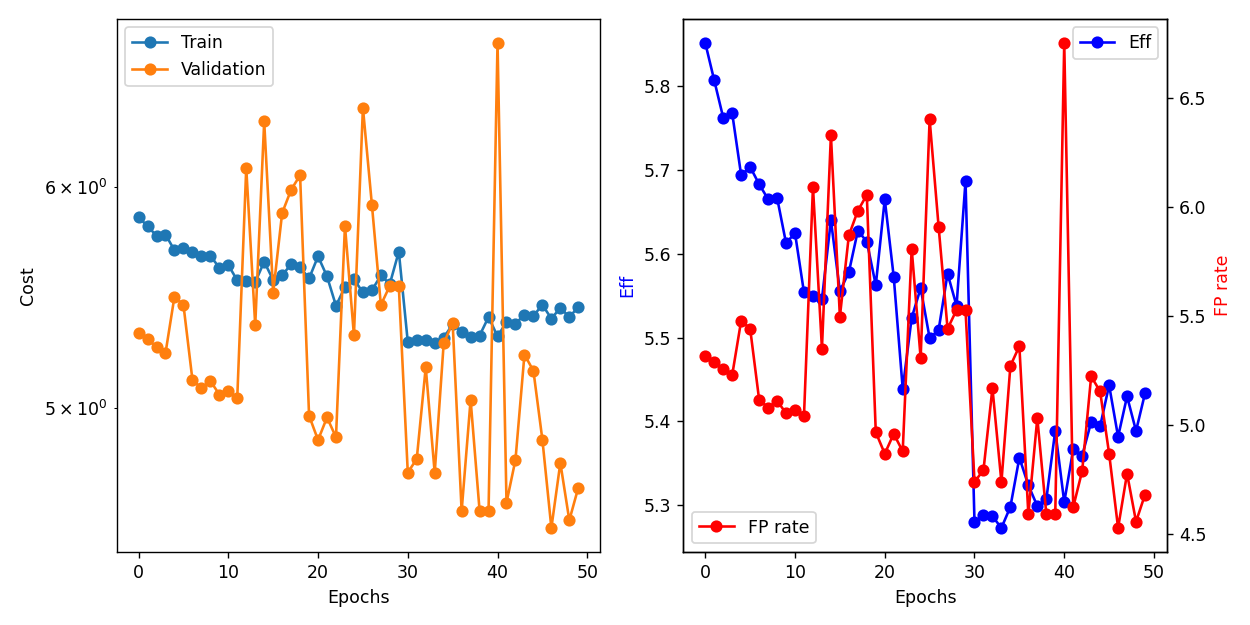

In [20]:
dual_train_plots(results.index,
                 results.cost, results.val,
                 results.cost, results.val)
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [21]:
from functions.utils import state_dict_to_vector
def angle_between(a, b):
    return np.arccos(np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)))

angle_grids = []
grid_size = 25
num_epochs = n_epochs
num_epochs2 = 0

ep_intervals = [(np.arange(0, num_epochs+num_epochs2+1, grid_size)[i], np.arange(0, num_epochs+num_epochs2+1, grid_size)[i+1]) for i in range(len(np.arange(0, num_epochs+num_epochs2+1, grid_size))-1)]

for interval in ep_intervals:
    
    these_param_states = []
    for i in range(interval[0], interval[1]):
        if i % 100 == 0:
            print(i)
        these_param_states.append(param_states[i])
        #print("Loaded", file_names[i])
        
    interval_size = len(these_param_states)-1    
    these_steps = [these_param_states[i+1]-these_param_states[i] for i in range(interval_size)]
    
    this_angle_grid = np.zeros((interval_size, interval_size))
    
    for i in range(interval_size):
        for j in range(i+1, interval_size):#range(i+1, interval_size):
            angle = angle_between(these_steps[i], these_steps[j])
            this_angle_grid[i,j] = angle
            this_angle_grid[j,i] = angle
            
    angle_grids.append(this_angle_grid)

0


<IPython.core.display.Javascript object>


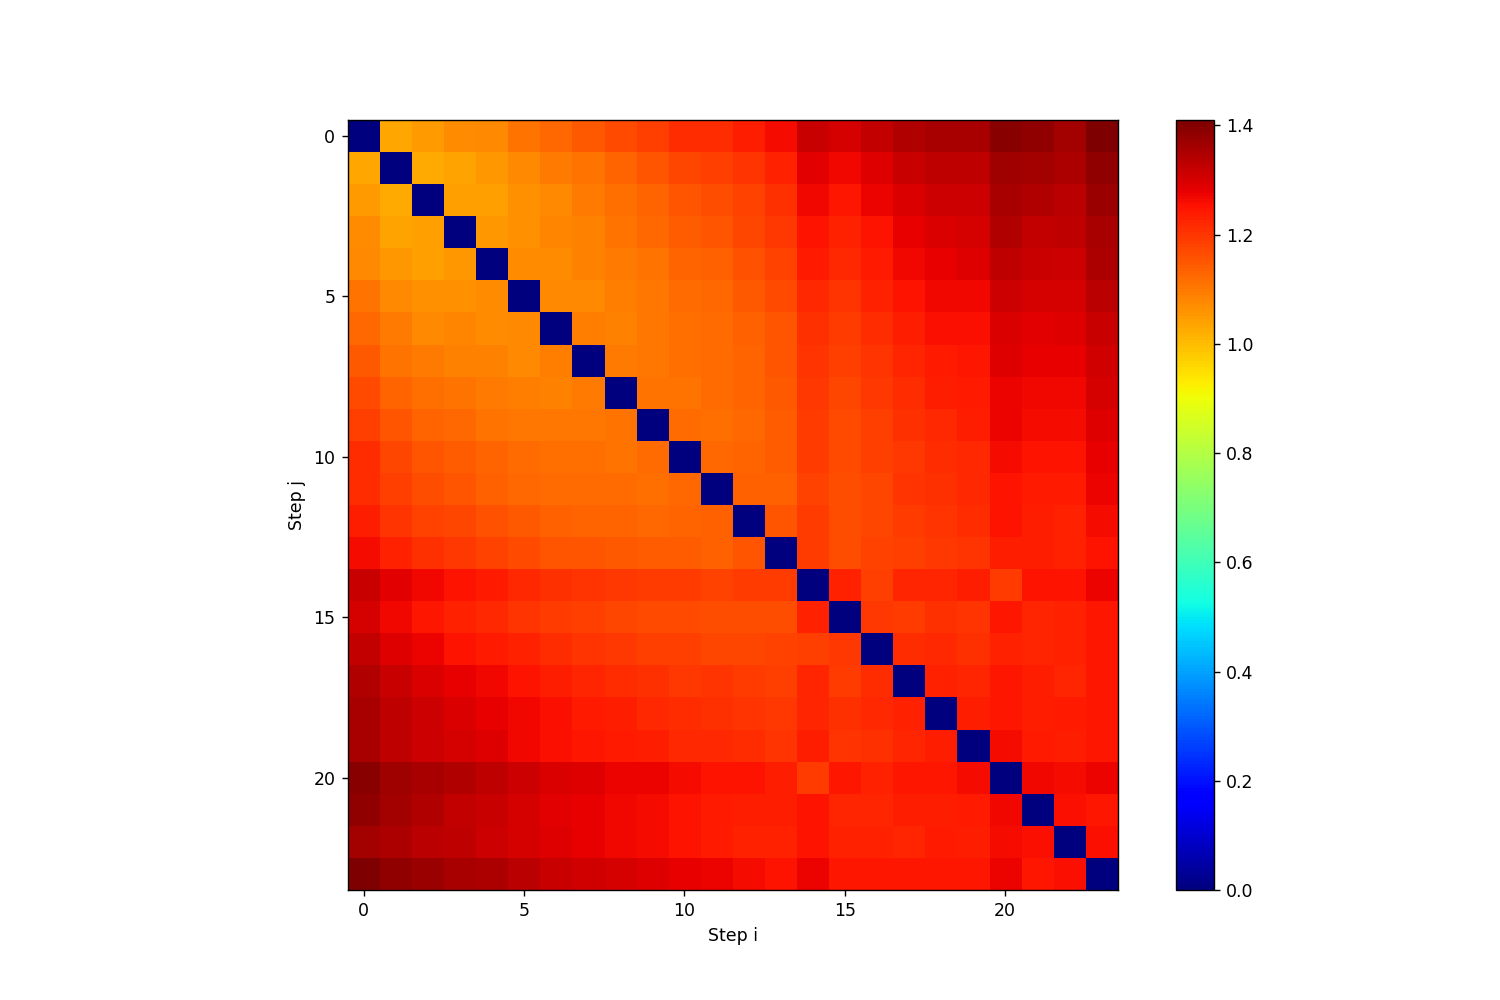

<IPython.core.display.Javascript object>


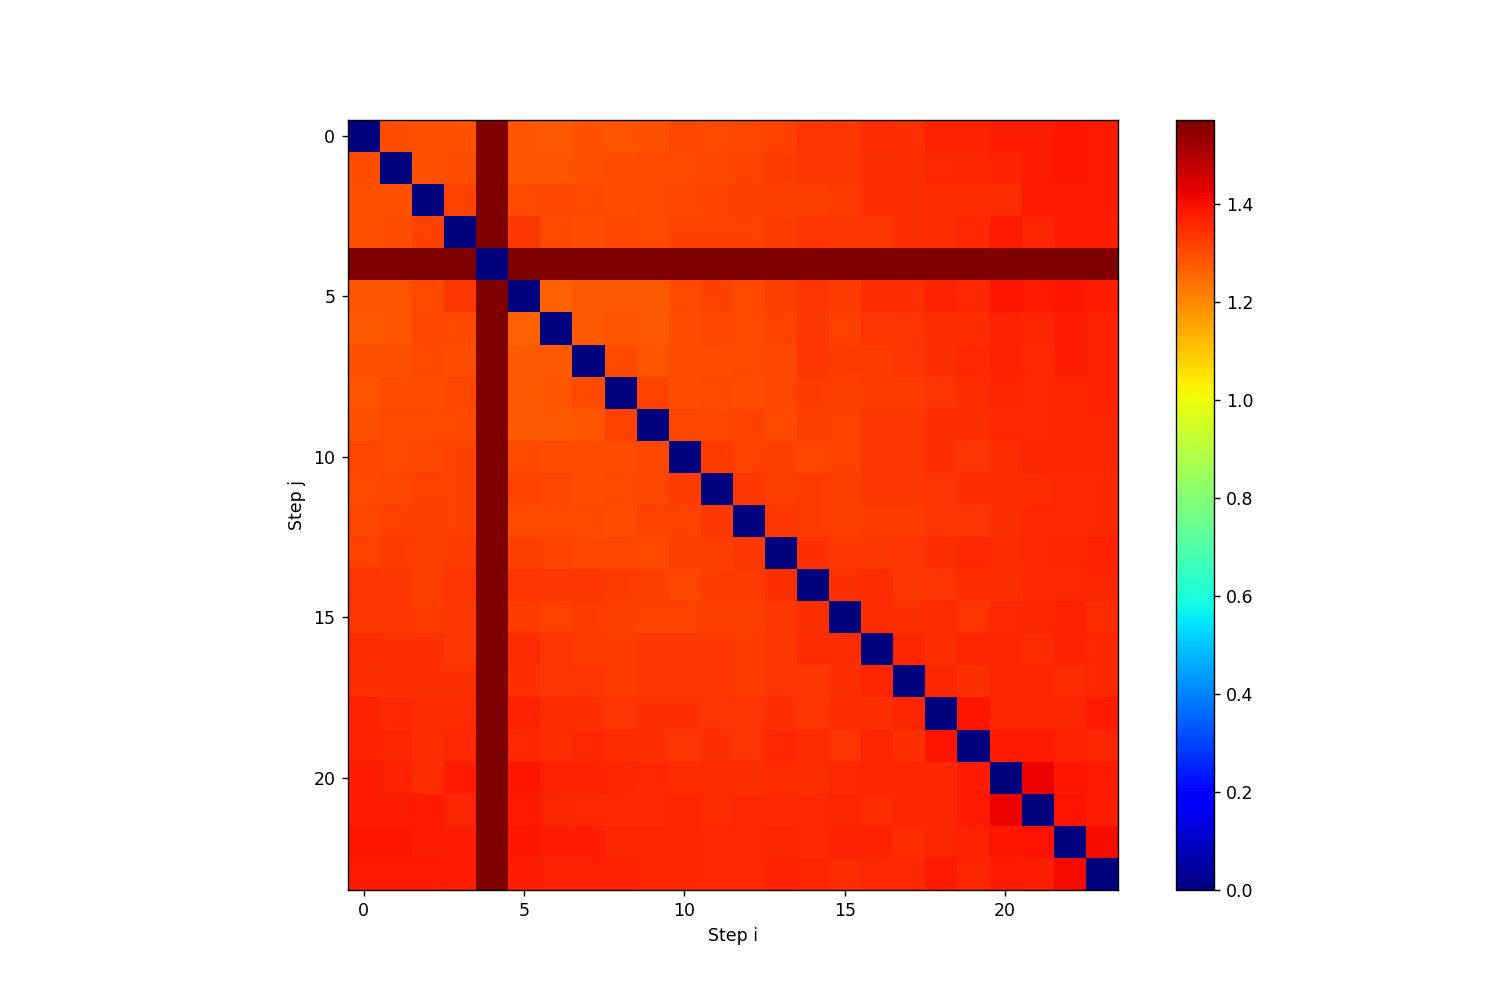

In [22]:
import matplotlib.colors as colors
import matplotlib.cm as cm

for angle_grid in angle_grids:
    plt.figure(figsize=(12,8))
    norm = colors.Normalize(vmin=np.amin(angle_grid), vmax=np.amax(angle_grid))   
    plt.imshow(angle_grid, cmap=cm.jet)
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.jet))
    plt.xlabel('Step i')
    plt.ylabel('Step j')
    
#print("num params:", len(these_param_states[0]))

In [23]:
from functions.plotting_DDplus_hists import load_data
from functions.utils import vector_to_state_dict

state_dicts = []
# num_epochs = 500
for i in np.arange(0, num_epochs, 10):
    state_dicts.append( (i, vector_to_state_dict(param_states[i], model)) )

data = load_data()

Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
majorAxis.shape =  (20000, 3)
minorAxis_1.shape =  (20000, 3)
minorAxis_2.shape =  (20000, 3)
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
A.shape =  (20000,)
majorAxis[iTrk][0][0] =  -0.00023452607
majorAxis[iTrk][1][0] =  -0.00047206535
majorAxis[iTrk][2][0] =  0.096502915
minorAxis_1[iTrk][0][0] =  -15.822749
minorAxis_1[iTrk][1][0] =  7.8608756
minorAxis_1[iTrk][2][0] =  -2.6228399e-08
minorAxis_2[iTrk][0][0] =  7.860759
minorAxis_2[iTrk][1][0] =  15.822513
minorAxis_2[iTrk][2][0] =  0.096502915
  
majorAxis[iTrk][0][0] =  -0.37655562
majorAxis[iTrk][1][0] =  0.2768704
majorAxis[iTrk][2][0] = 

[0, 10, 20, 30, 40]
labels shape: torch.Size([16, 12000])
nEvts: 16 | nFeatures: 4000
y shape: torch.Size([16, 3, 4000])
y shape: torch.Size([16, 4000, 3])


<IPython.core.display.Javascript object>


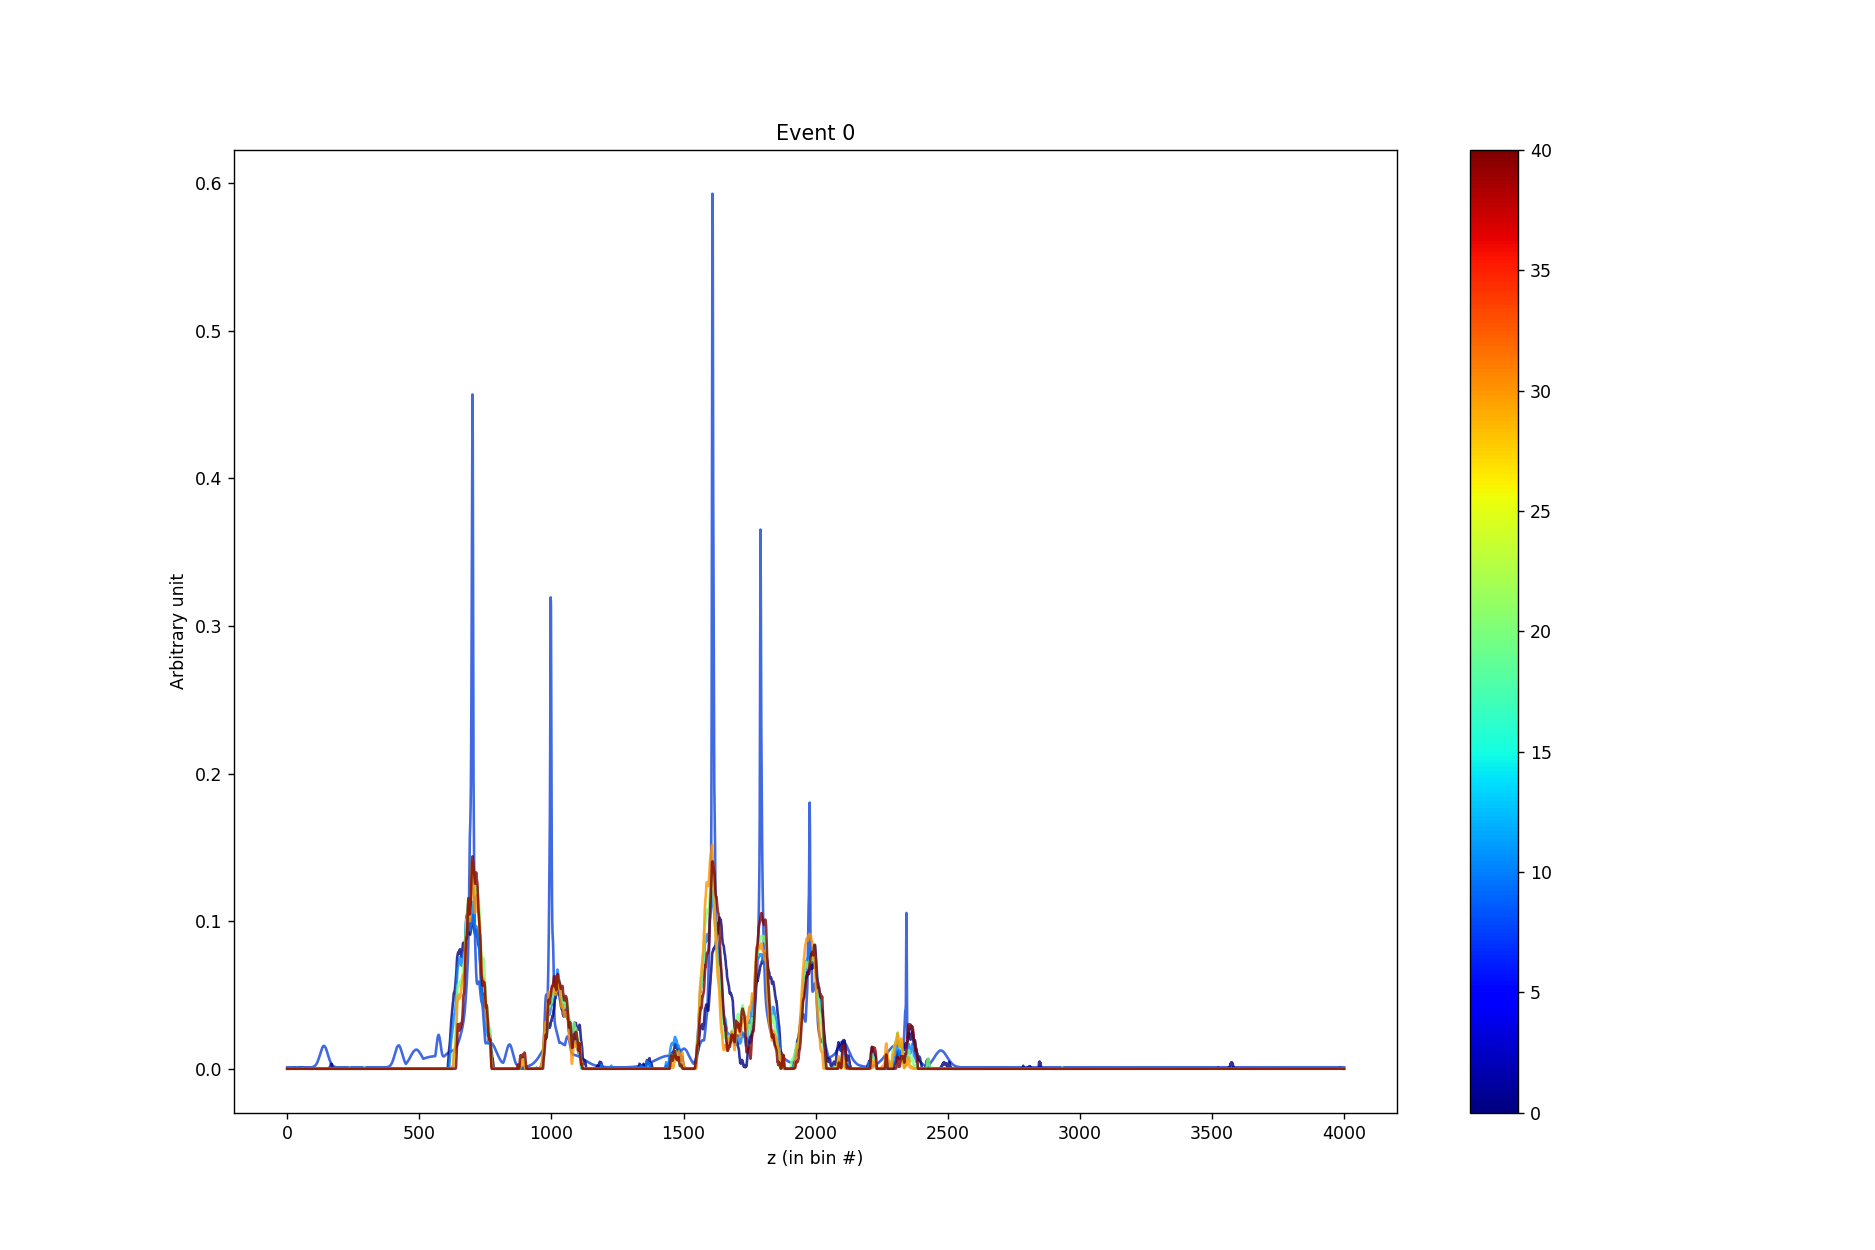

<IPython.core.display.Javascript object>


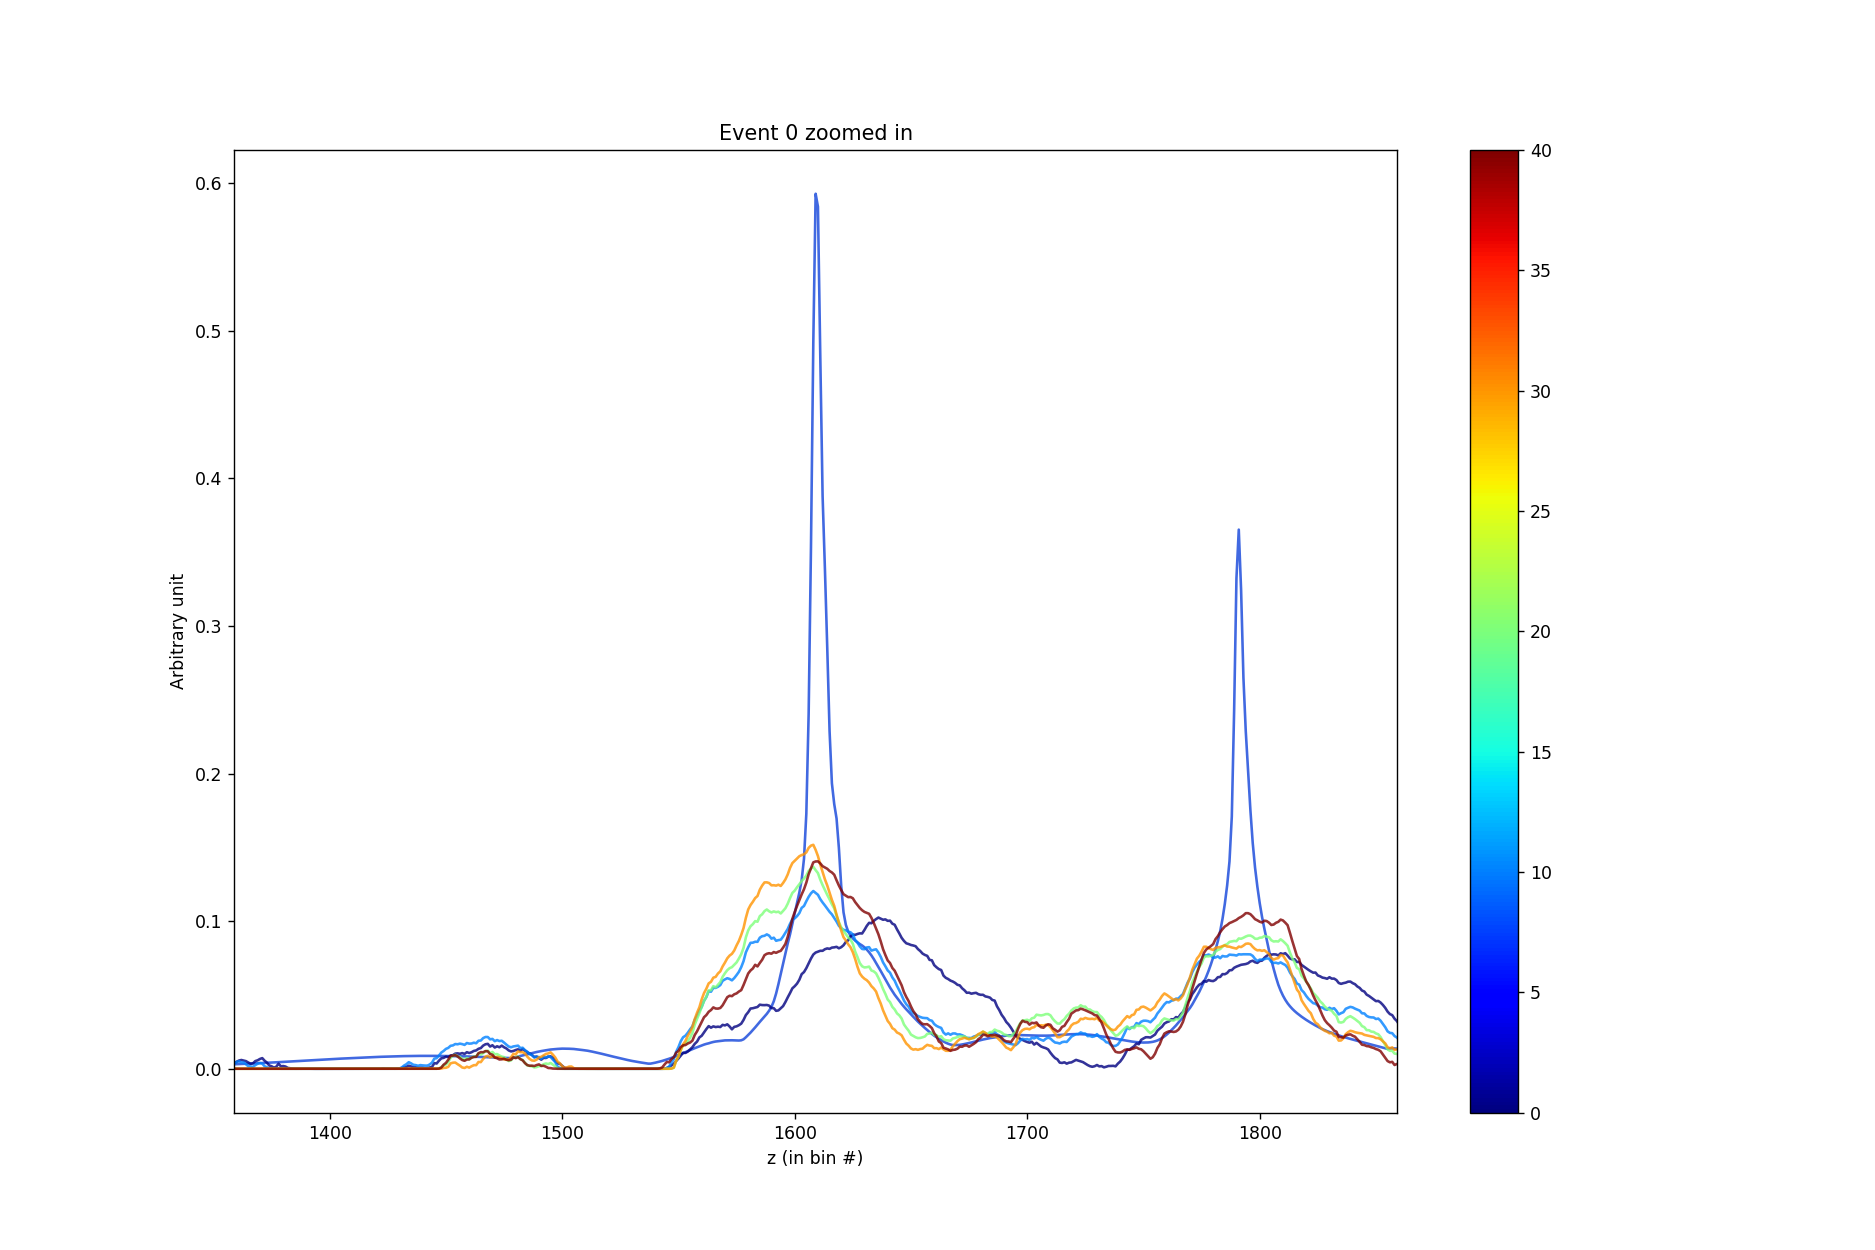

<IPython.core.display.Javascript object>


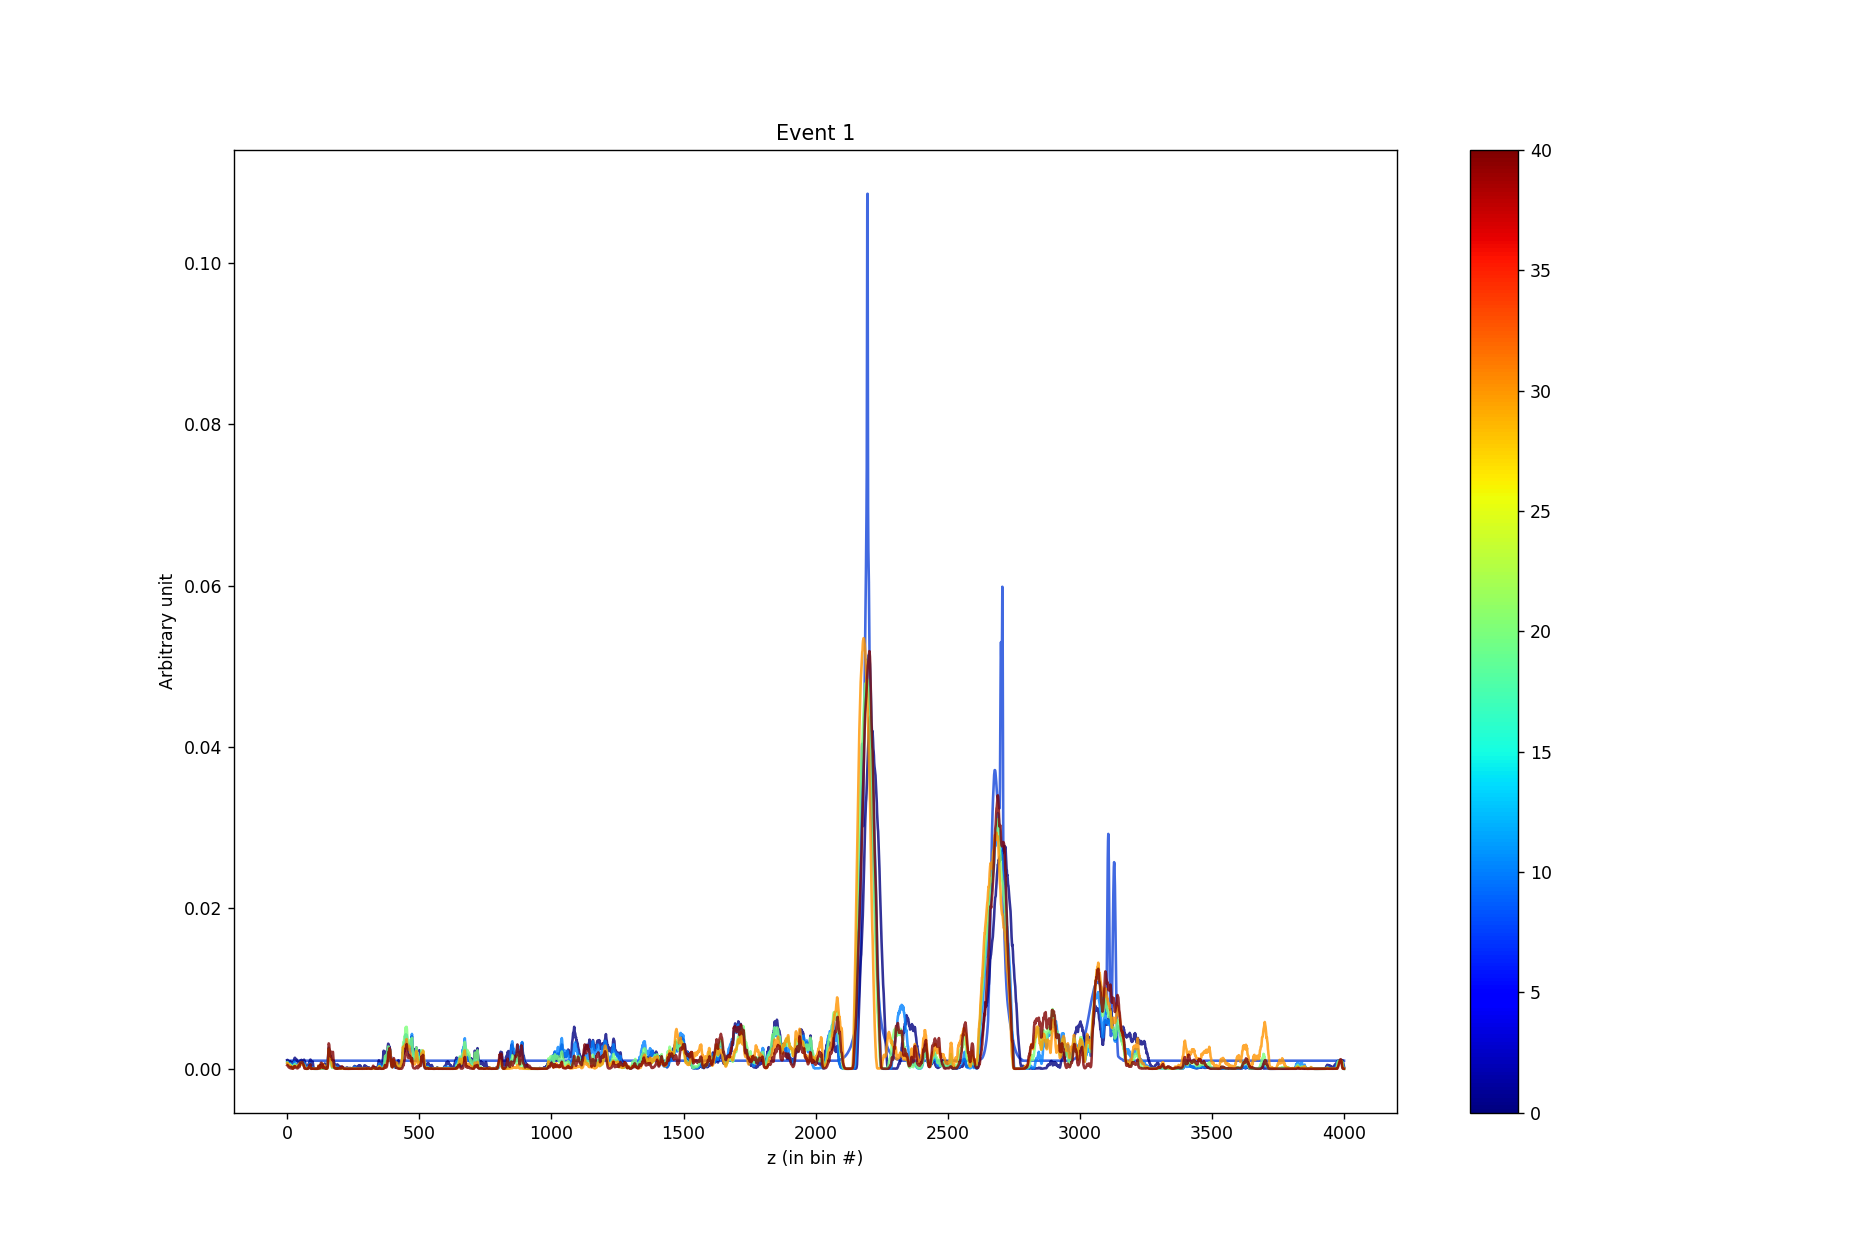

<IPython.core.display.Javascript object>


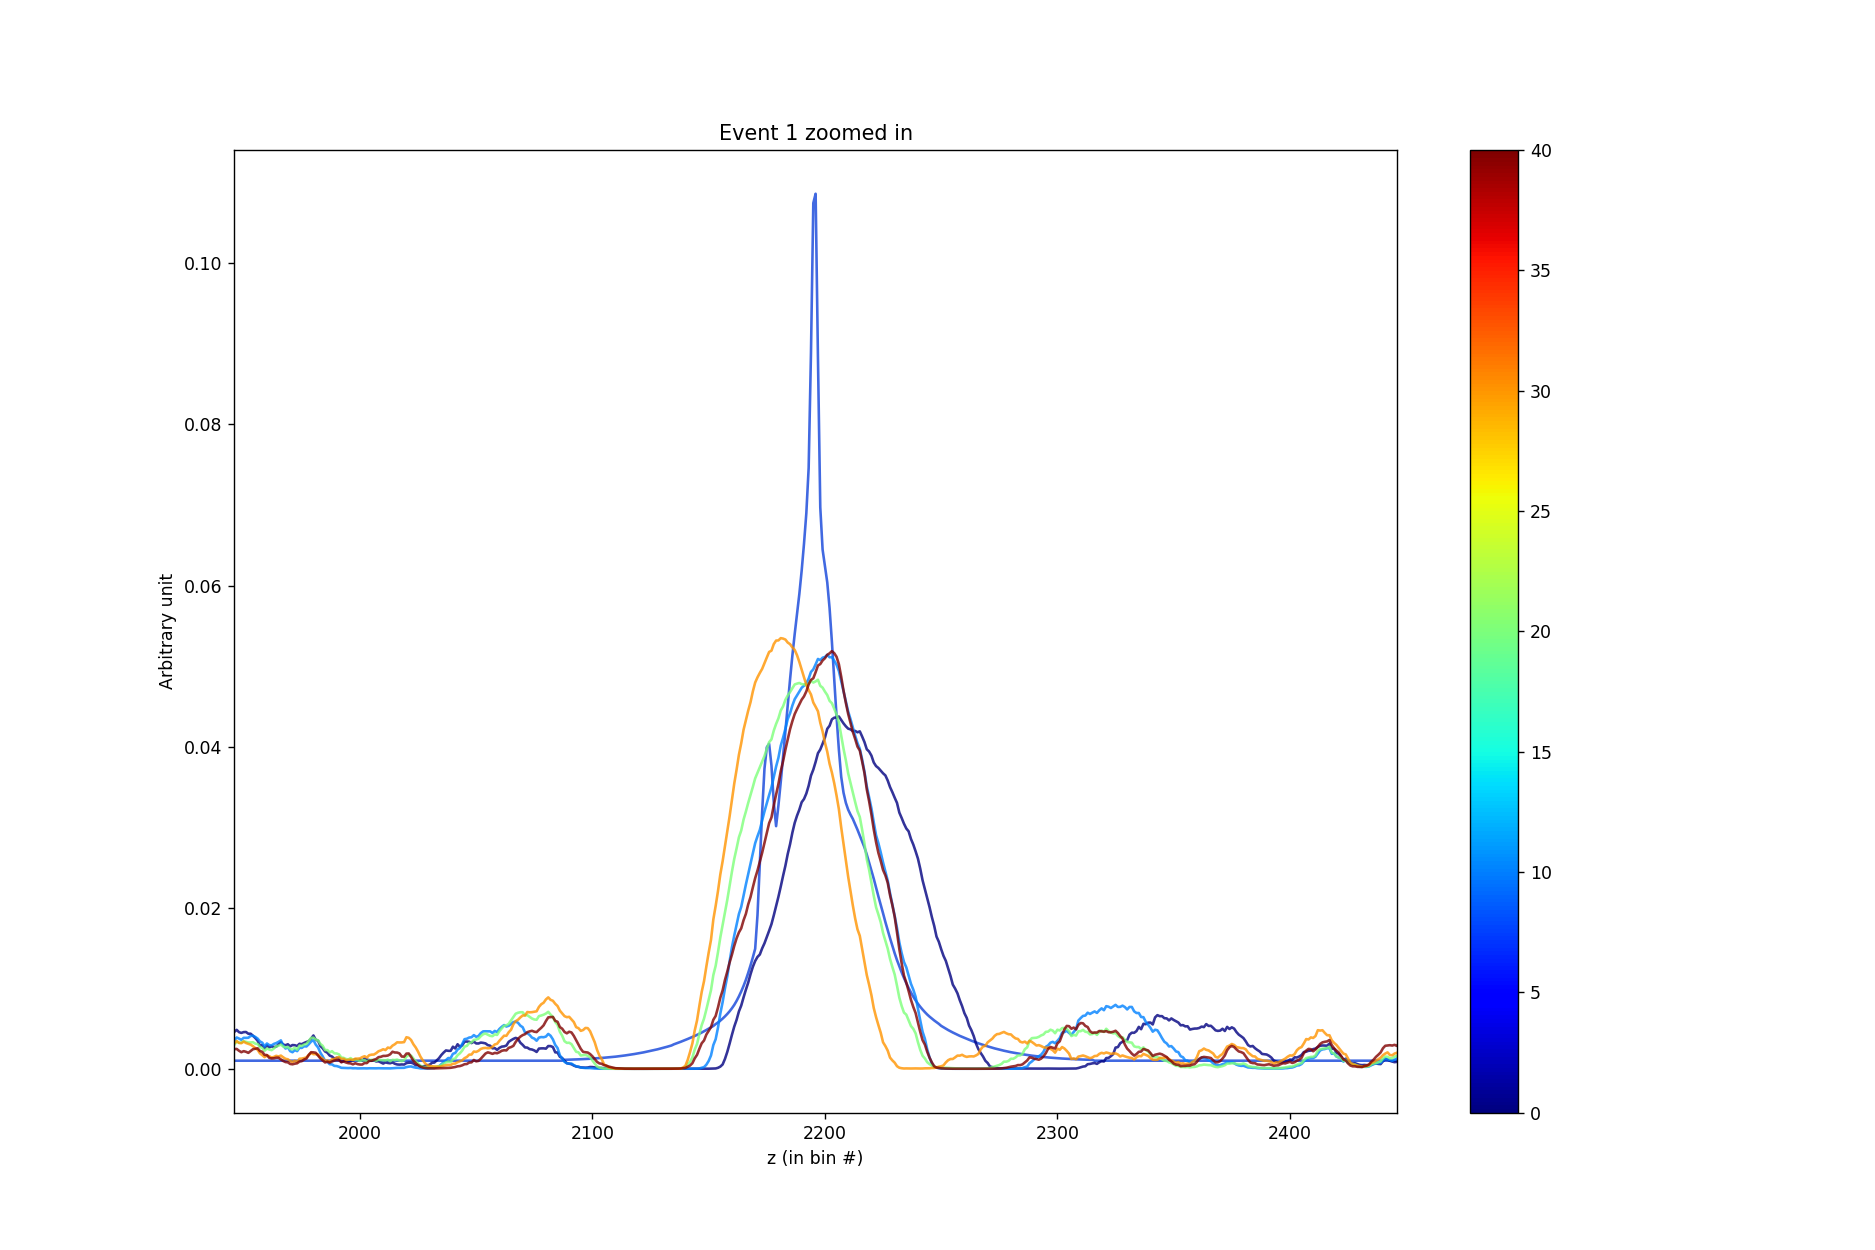

<IPython.core.display.Javascript object>


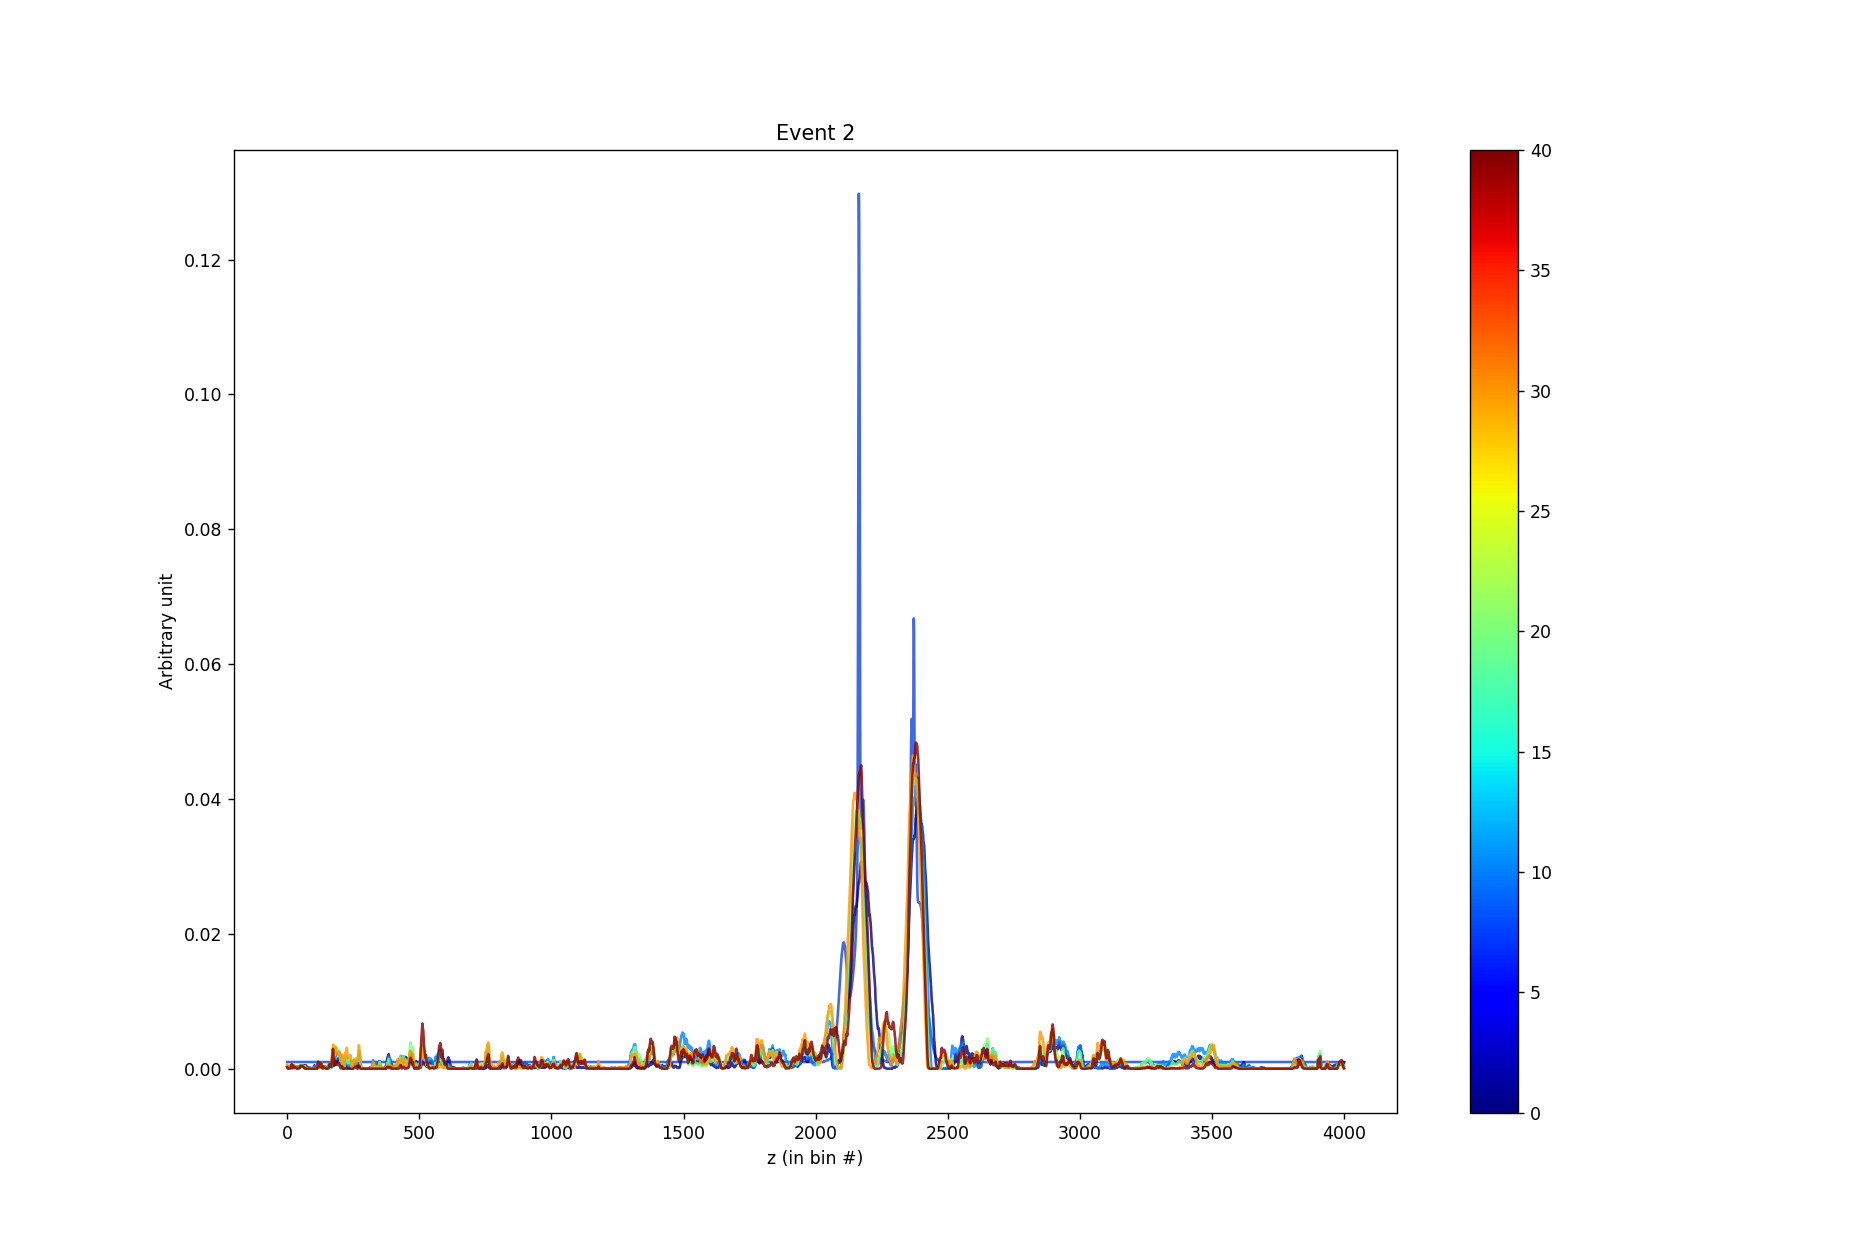

<IPython.core.display.Javascript object>


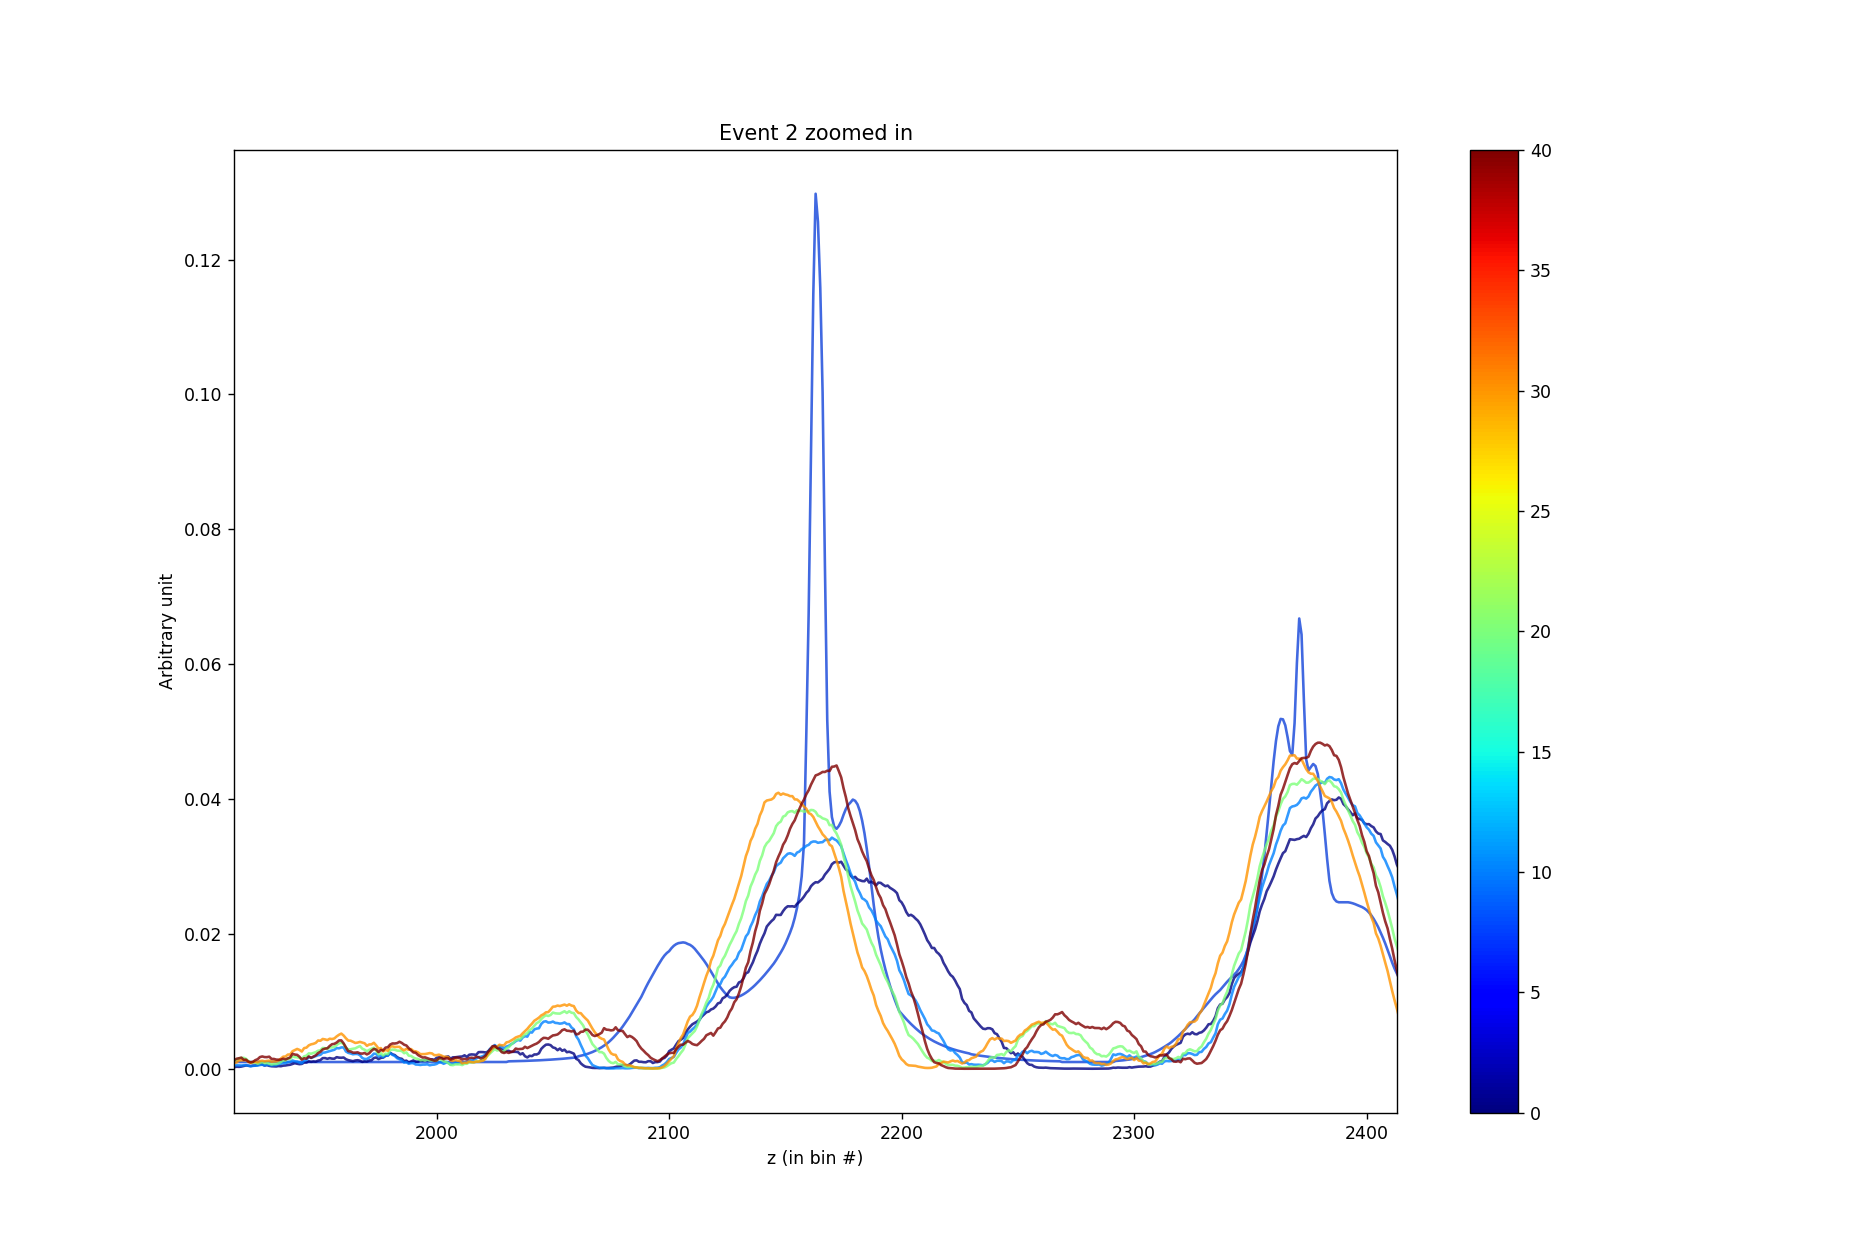

<IPython.core.display.Javascript object>


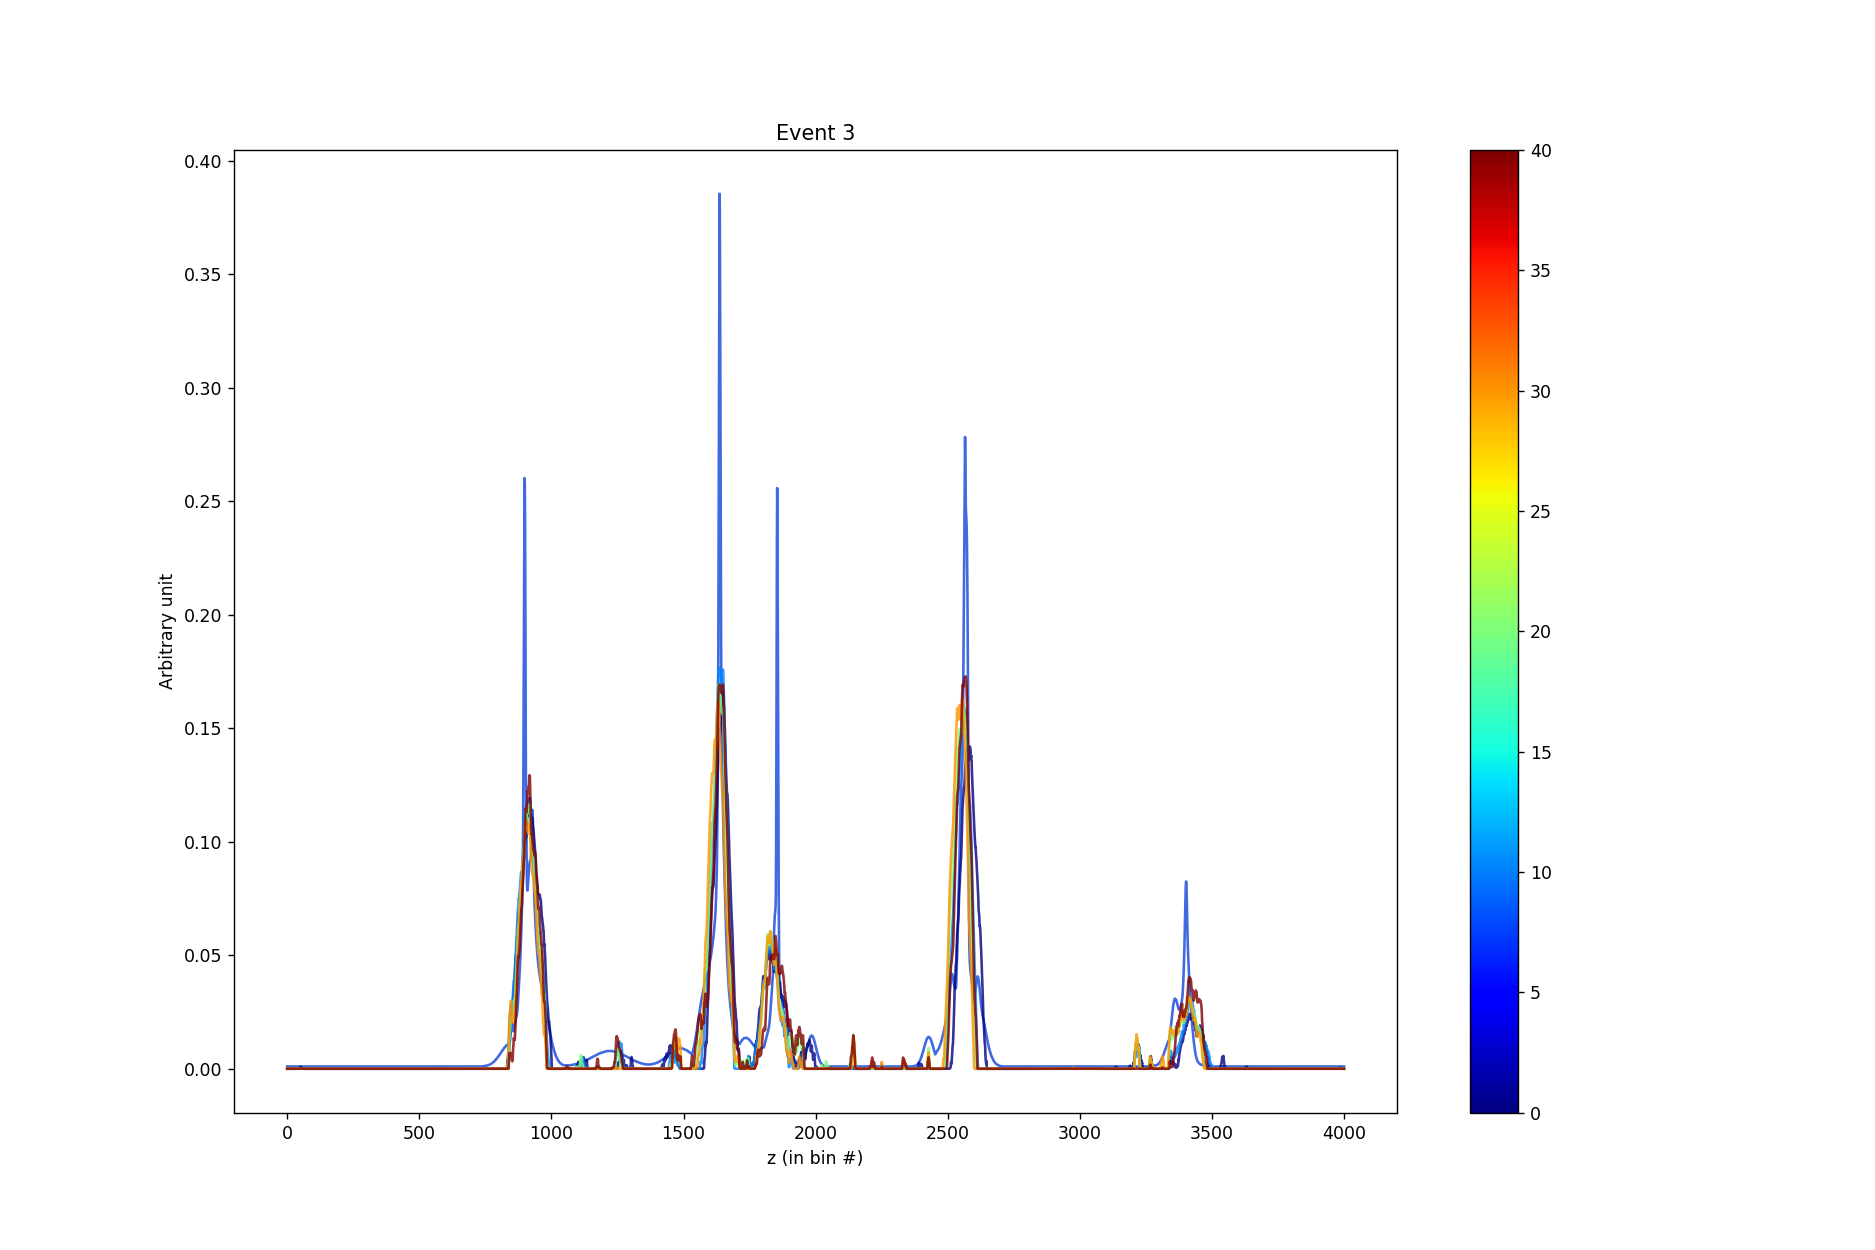

<IPython.core.display.Javascript object>


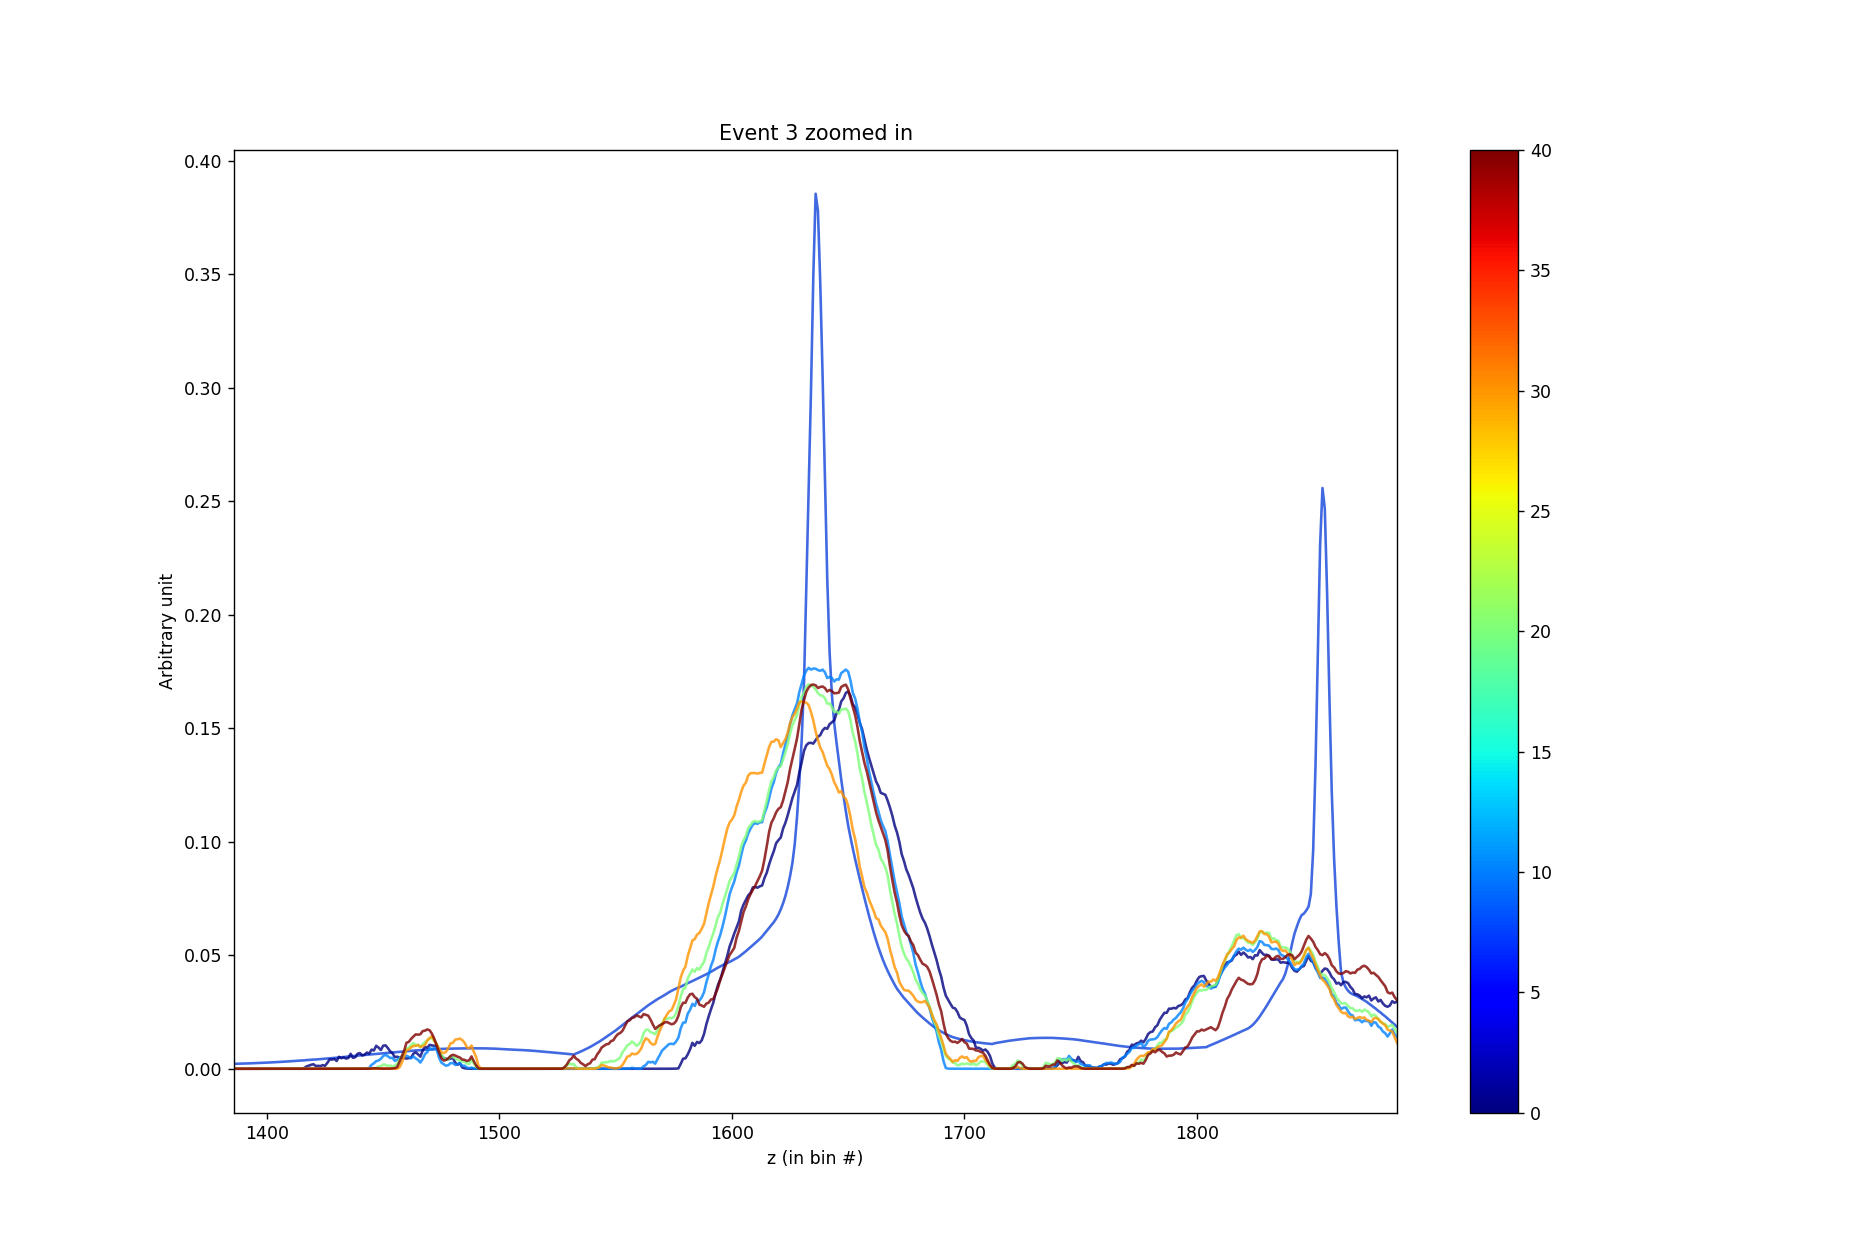

<IPython.core.display.Javascript object>


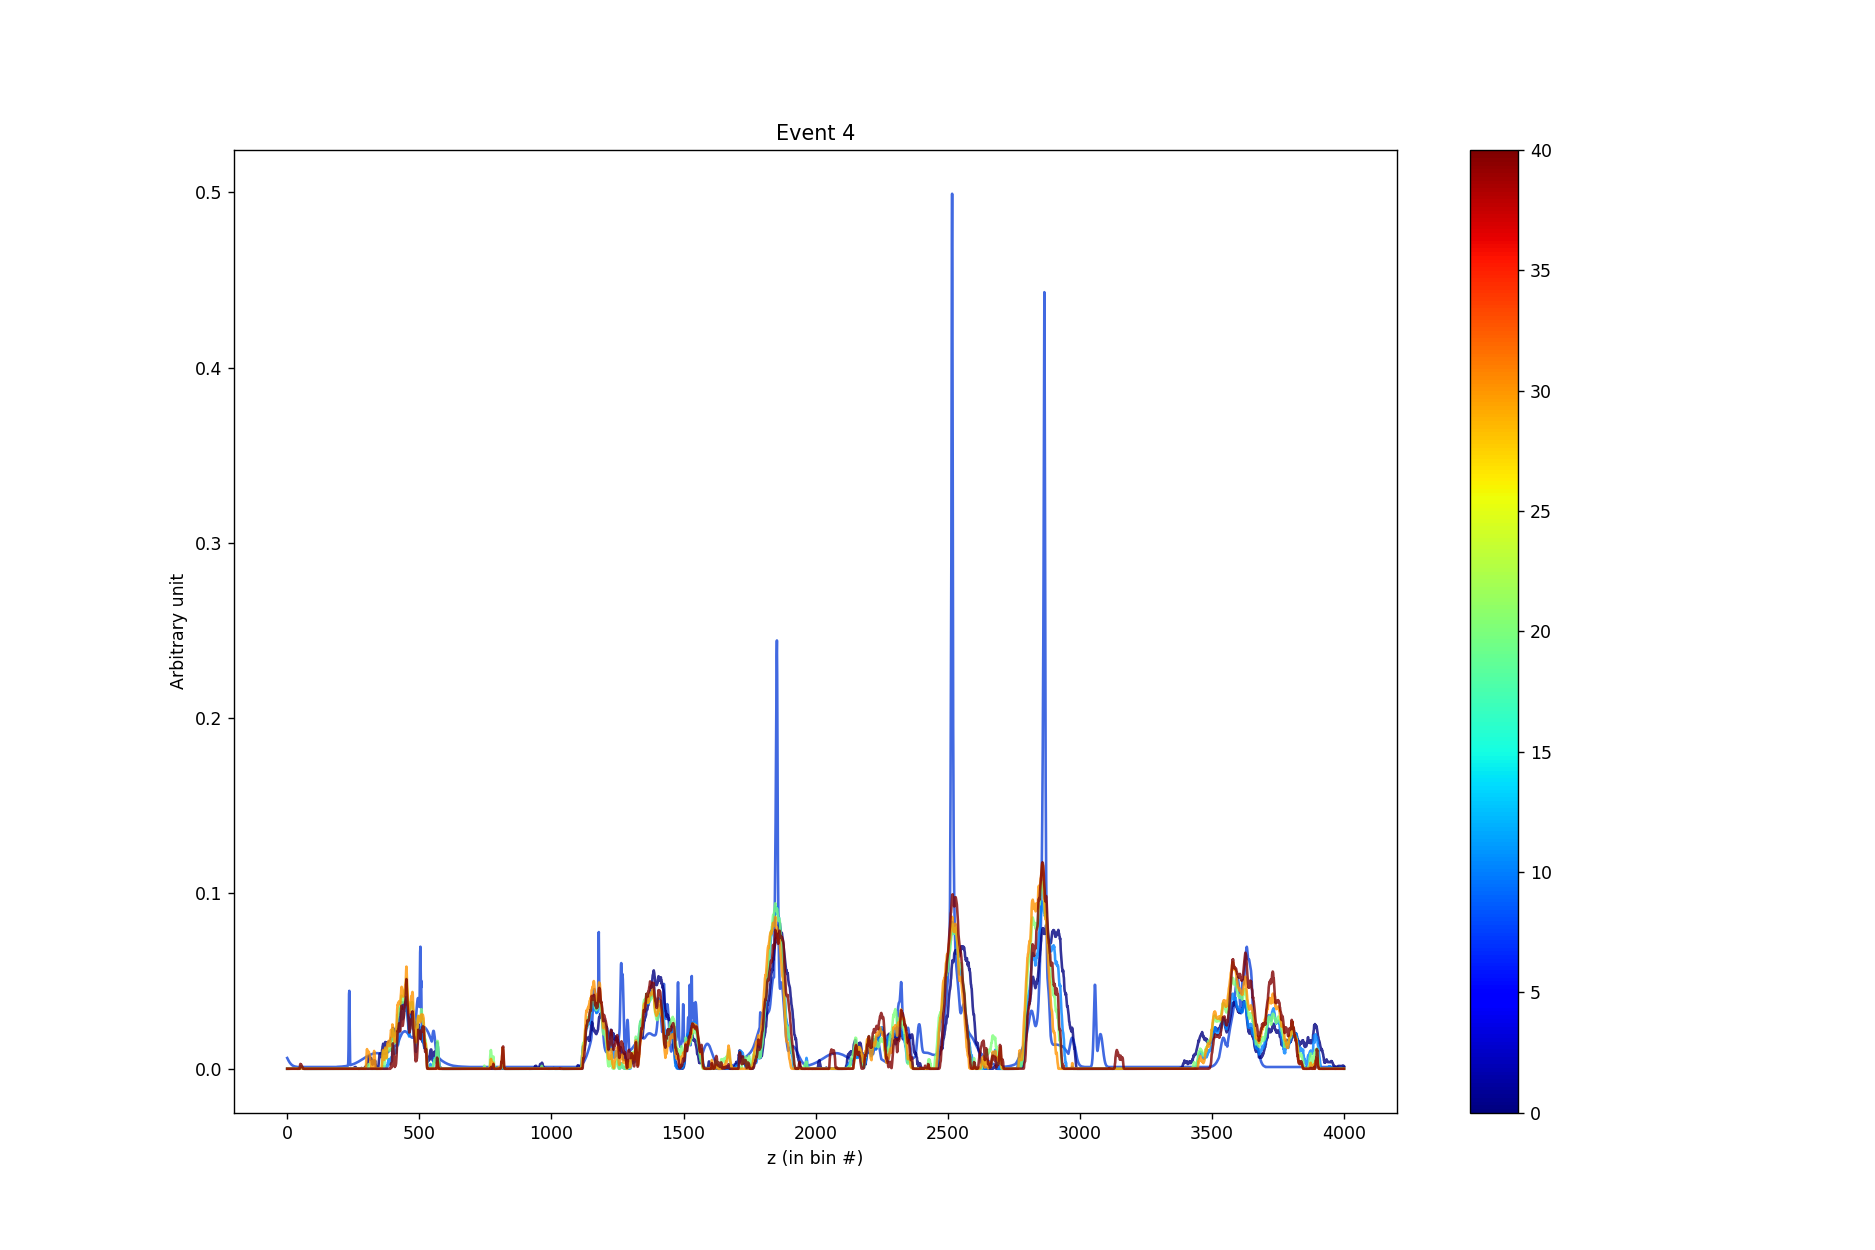

<IPython.core.display.Javascript object>


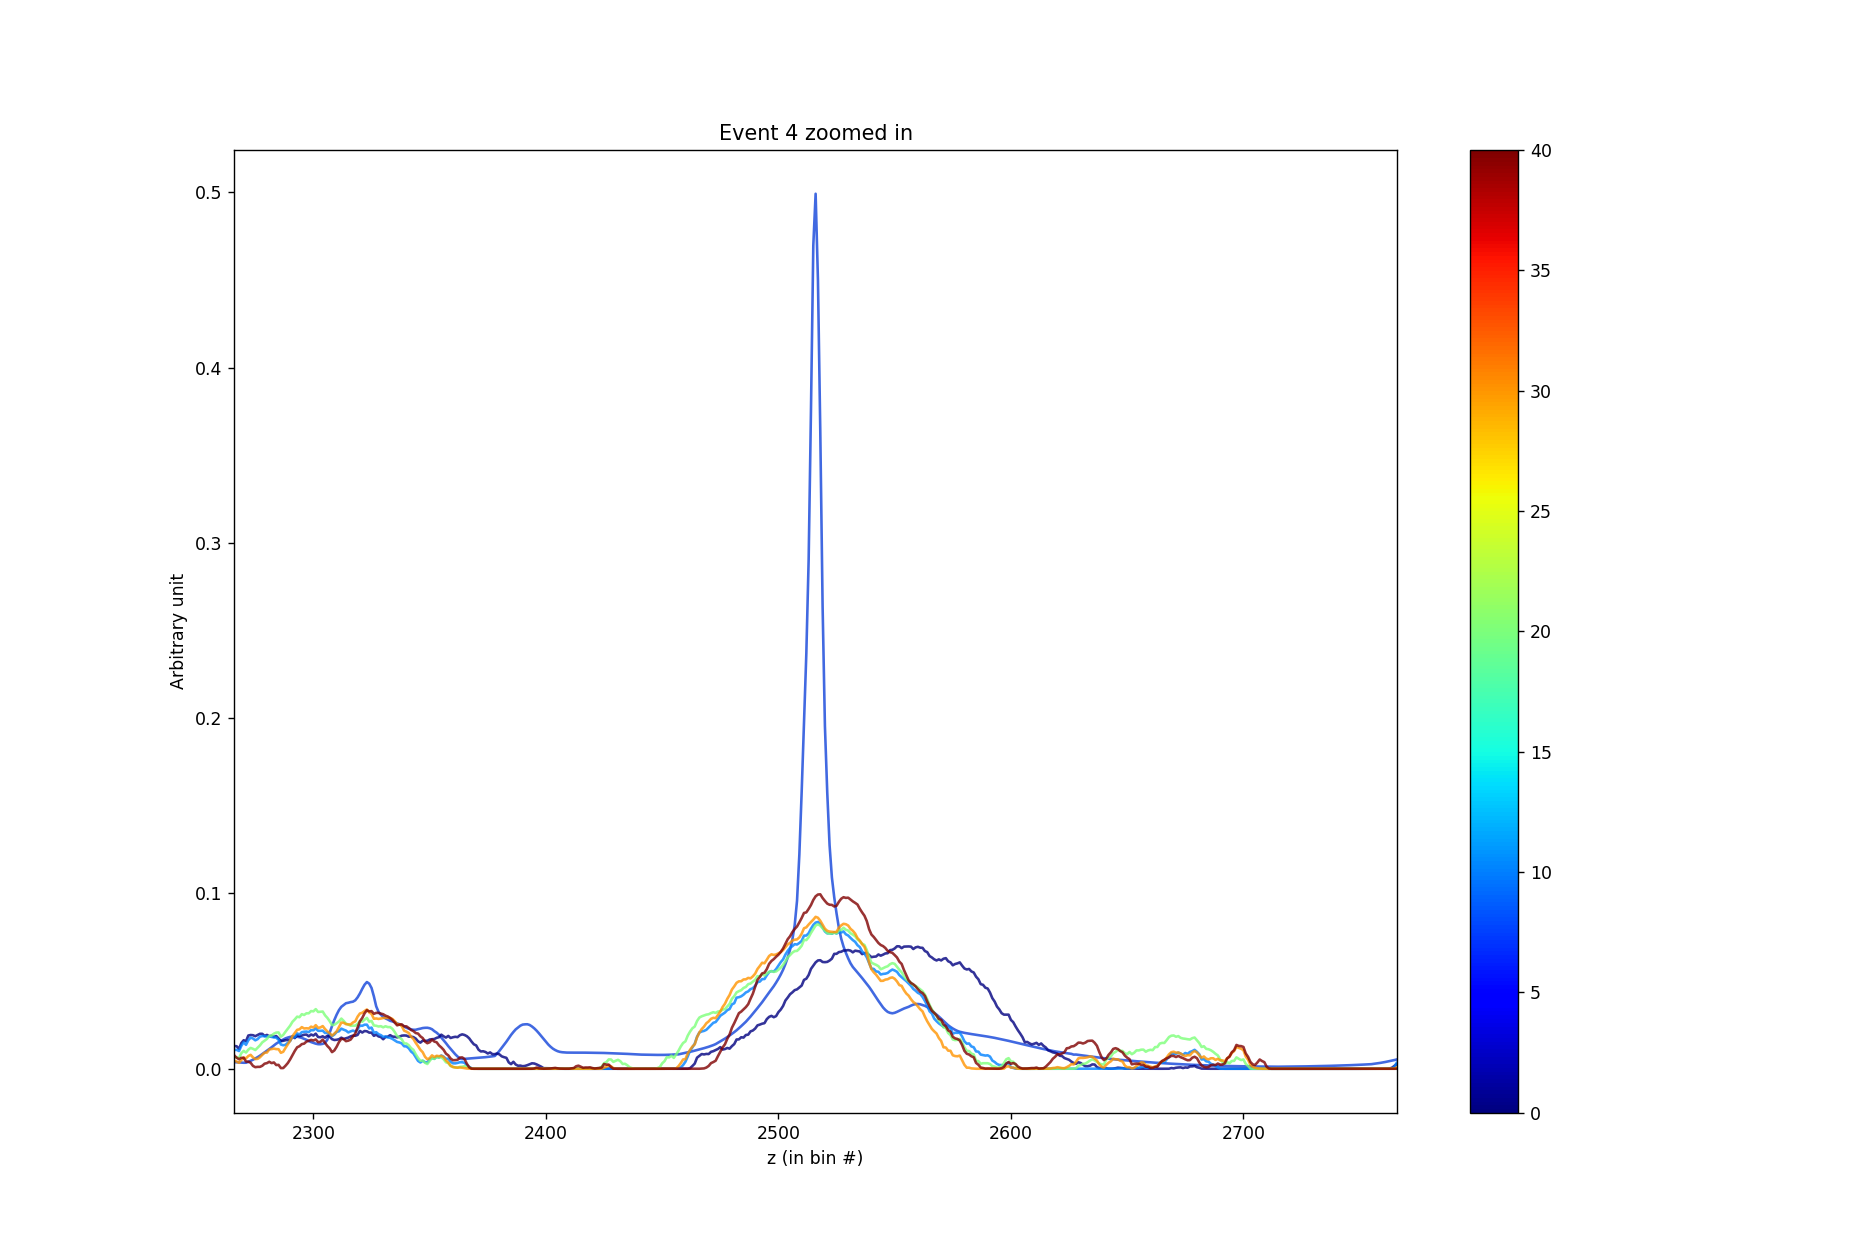

In [24]:
from functions.plotting_DDplus_hists import plot_DDplus_hists as Plot
Plot(state_dicts, data)